## United States 2020 Census data

In this tutorial, you will explore various subsets of geographic data in the [United States 2020 Census](https://www.census.gov/programs-surveys/decennial-census/decade/2020/2020-census-main.html). You will learn how the data is structured and how to access the data.

The data consists of two groups:
1. **Census data by census block boundaries**: This group contains data for each census block, grouped by US counties. Census blocks are the smallest available unit made available by the US Census Bureau. This group also includes population totals broken down by census block, available in a second table.
2. **Census data by cartographic boundaries**: This group contains data that is aggregated by 29 different geographic boundaries, ranging from block groups to regional datasets such as metropolitan divisions and states. This group does not include any demographic information.

This notebook contains details about all geographic datasets within the 2020 census data. Use the table of contents to jump to any section relevant to you. For a brief introduction, [Accessing US Census data with the Planetary Computer STAC API](../datasets/us-census/us-census-example.ipynb).

### Table of Contents

* [Accessing the Data](#Accessing-the-Data)
* [Import Dependencies](#Import-Dependencies)
* [Census data by census block boundaries](#Census-data-by-census-block-boundaries)
  * [Census Block Boundaries](#Census-Block-Boundaries) (8,180,866 features)
* [Census data by cartographic boundaries](#Census-data-by-cartographic-boundaries)
  * [American Indian Area Geographies](#American-Indian-Area-Geographies)
    * [American Indian/Alaska Native Areas/Hawaiian Home Lands](#American-Indian/Alaska-Native-Areas/Hawaiian-Home-Lands-(AIANNH)) (704 features)
    * [American Indian Tribal Subdivisions](#American-Indian-Tribal-Subdivisions-(AITSN)) (484 features)
    * [Alaska Native Regional Corporations](#Alaska-Native-Regional-Corporations-(ANRC)) (12 features)
    * [Tribal Block Groups](#Tribal-Block-Groups-(TBG)) (934 features)
    * [Tribal Census Tracts](#Tribal-Census-Tracts-(TTRACT)) (492 features)
  * [Census Block Groups](#Census-Block-Groups-(BG)) (242,305 features)
  * [Census Tracts](#Census-Tracts-(TRACT)) (85,190 features)
  * [Congressional Districts](#Congressional-Districts:-116th-Congress-(CD116)) (441 features)
  * [Consolidated Cities](#Consolidated-Cities-(CONCITY)) (8 features)
  * [Counties](#Counties-(COUNTY)) (3,234 features)
  * [Counties within Congressional Districts](#Counties-within-Congressional-Districts:-116th-Congress-(COUNTY_within_CD116)) (3,836 features)
  * [County Subdivisions](#County-Subdivisions-(COUSUB)) (36,502 features)
  * [Divisions](#Divisions-(DIVISION)) (9 features)
  * [Metropolitan and Micropolitan Statistical Areas and Related Statistical Areas](#Metropolitan-and-Micropolitan-Statistical-Areas-and-Related-Statistical-Areas)
    * [Core Based Statistical Areas](#Core-Based-Statistical-Areas-(CBSA)) (939 features)
    * [Combined Statistical Areas](#Combined-Statistical-Areas-(CSA)) (175 features)
    * [Metropolitan Divisions](#Metropolitan-Divisions-(METDIV)) (31 features)
    * [New England City and Town Areas](#New-England-City-and-Town-Areas-(NECTA)) (40 features)
    * [New England City and Town Areas Division](#New-England-City-and-Town-Areas-Division(NECTADIV)) (11 features)
    * [Combined New England City and Town Areas](#Combined-New-England-City-and-Town-Areas-(CNECTA)) (7 features)
  * [Places](#Places-(PLACE)) (32,188 features)
  * [Regions](#Regions-(REGION)) (4 features)
  * [School Districts](#School-Districts)
    * [Elementary](#School-Districts---Elementary-(ELSD)) (1,945 features)
    * [Secondary](#School-Districts---Secondary-(SCSD)) (473 features)
    * [Unified](#School-Districts---Unified-(UNSD)) (10,867 features)
  * [State Legislative Districts](#State-Legislative-Districts)
    * [Lower Chamber](#State-Legislative-Districts---Lower-Chamber-(SLDL)) (4,829 features)
    * [Upper Chamber](#State-Legislative-Districts---Upper-Chamber-(SLDU)) (1,958 features)
  * [States](#States-(STATE)) (56 features)
  * [Subbarrios](#Subbarrios-(SUBBARRIO)) (145 features)
  * [United States Outline](#United-States-Outline) (1 feature)
  * [Voting Districts](#Voting-Districts-(VTD)) (158,320 features)

### Accessing the Data

Like other datasets on the Planetary Computer, US Census datasets are cataloged using [STAC](https://stacspec.org/). Each table, corresponding a particular level of cartographic aggregation, is available as a STAC item under the `us-census` collection.

In [1]:
import pystac_client

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
census = catalog.get_collection("us-census")
census

<CollectionClient id=us-census>

The actual files themselves are stored as [Apache Parquet](https://parquet.apache.org/) datasets in Azure Blob Storage. These files can be loaded with pandas or geopandas, or dask-geopandas if the files are larger than memory.

Loading each of the tables will follow the same basic pattern:

1. Get the Item from the collection with `census.get_item(item_id)`
2. Sign the item with `planetary_computer.sign` to enable you to download the parquet dataset from Blob Storage
3. Use the `href` and `table:storage_options` fields from the `data` asset to load the data with `read_parquet`.

### Import Dependencies

We'll import a few libraries to use for accessing and plotting the data. In particular,[geopandas](https://geopandas.org/) and [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to load the parquet datasets and [contextily](https://github.com/geopandas/contextily). Before getting started, make sure you have these two dependencies installed and imported:

In [2]:
import geopandas
import dask_geopandas
import contextily as ctx
import planetary_computer

### Census data by census block boundaries

The first block of data is organized by [Census blocks](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_5). Census blocks are the smallest geographic grouping available in the current dataset. There are over eight million census blocks, resulting in large datasets. To facilitate parallelism and accessing subsets of the data, the Census block-level data are partitioned by state.

There are two tables available at the Census block level: "geo", containing the boundaries and other data about the block, and "population", containing the population counts in that geometry by various features.

**geo**

* GEOID = Concatenation of county FIPS code, census tract code, and census block number. *In pandas and Dask, this is used as the index*.
* STATEFP = State FIPS code
* COUNTYFP = County FIPS code
* TRACTCE = Census Tract code
* BLOCKCE = Census Block code
* ALAND = Current land area
* AWATER = Current water area
* INTPTLAT = Current latitude of the internal point
* INTPTLON = Current longitude of the internal point
* geometry = Coordinates for block polygons

In [3]:
asset = planetary_computer.sign(
    census.get_item("2020-census-blocks-geo").assets["data"]
)

geo = dask_geopandas.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
)
geo

Dask GeoDataFrame Structure:
                           STATEFP           COUNTYFP TRACTCE BLOCKCE  ALAND AWATER INTPTLAT INTPTLON  geometry
npartitions=56                                                                                                 
010010201001000  category[unknown]  category[unknown]   int64   int64  int64  int64  float64  float64  geometry
020130001001000                ...                ...     ...     ...    ...    ...      ...      ...       ...
...                            ...                ...     ...     ...    ...    ...      ...      ...       ...
780109701001000                ...                ...     ...     ...    ...    ...      ...      ...       ...
780309900000008                ...                ...     ...     ...    ...    ...      ...      ...       ...
Dask Name: read-parquet, 56 tasks

**pop**

The population table contains may columns. Two are important to call out:

* GEOID = Concatenation of county FIPS code, census tract code, and census block number. *In pandas and Dask, this is used as the index*.
* P0010001 = Total Block Population

The remainder of the columns provide the Block's population faceted by various features. [This document (pdf)](https://www2.census.gov/programs-surveys/decennial/2010/technical-documentation/complete-tech-docs/summary-file/nsfrd.pdf) documents the meaning of all the additional variables.

In [4]:
import dask.dataframe

asset = planetary_computer.sign(
    census.get_item("2020-census-blocks-population").assets["data"]
)

pop = dask.dataframe.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
)
pop

Dask DataFrame Structure:
                P0010001 P0010002 P0010003 P0010004 P0010005 P0010006 P0010007 P0010008 P0010009 P0010010 P0010011 P0010012 P0010013 P0010014 P0010015 P0010016 P0010017 P0010018 P0010019 P0010020 P0010021 P0010022 P0010023 P0010024 P0010025 P0010026 P0010027 P0010028 P0010029 P0010030 P0010031 P0010032 P0010033 P0010034 P0010035 P0010036 P0010037 P0010038 P0010039 P0010040 P0010041 P0010042 P0010043 P0010044 P0010045 P0010046 P0010047 P0010048 P0010049 P0010050 P0010051 P0010052 P0010053 P0010054 P0010055 P0010056 P0010057 P0010058 P0010059 P0010060 P0010061 P0010062 P0010063 P0010064 P0010065 P0010066 P0010067 P0010068 P0010069 P0010070 P0010071 P0020001 P0020002 P0020003 P0020004 P0020005 P0020006 P0020007 P0020008 P0020009 P0020010 P0020011 P0020012 P0020013 P0020014 P0020015 P0020016 P0020017 P0020018 P0020019 P0020020 P0020021 P0020022 P0020023 P0020024 P0020025 P0020026 P0020027 P0020028 P0020029 P0020030 P0020031 P0020032 P0020033 P0020034 P0020035 P0020036 P0020037 P0020038 P0020039 P0020040 P0020041 P0020042 P0020043 P0020044 P0020045 P0020046 P0020047 P0020048 P0020049 P0020050 P0020051 P0020052 P0020053 P0020054 P0020055 P0020056 P0020057 P0020058 P0020059 P0020060 P0020061 P0020062 P0020063 P0020064 P0020065 P0020066 P0020067 P0020068 P0020069 P0020070 P0020071 P0020072 P0020073
npartitions=52                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
010010201001000    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64    int64
020130001001000      ...      ...     

The datasets use `GEOID` as their index and are partitioned by state, so we can use the FIPS codes [efficiently access subsets](https://docs.dask.org/en/latest/dataframe-best-practices.html#use-the-index) of the data.

In [5]:
start = [x for x in geo.divisions if x.startswith("44")][0]
stop = "4499"

ri = geo.loc[start:stop].compute()
ri.head()

STATEFP COUNTYFP  TRACTCE  BLOCKCE  ALAND  AWATER   INTPTLAT  \
GEOID                                                                          
440010301001000      44      001    30100     1000   5329       0  41.765149   
440010301001001      44      001    30100     1001   6001       0  41.765003   
440010301001002      44      001    30100     1002  11821       0  41.764453   
440010301001003      44      001    30100     1003  16049       0  41.763871   
440010301001004      44      001    30100     1004   5398       0  41.764249   

                  INTPTLON                                           geometry  
GEOID                                                                          
440010301001000 -71.333153  POLYGON ((-71.33394 41.76482, -71.33266 41.765...  
440010301001001 -71.332271  POLYGON ((-71.33301 41.76503, -71.33235 41.765...  
440010301001002 -71.332507  POLYGON ((-71.33343 41.76474, -71.33324 41.764...  
440010301001003 -71.332863  POLYGON ((-71.33430 41.76413, -71.33410 41.764...  
440010301001004 -71.334446  POLYGON ((-71.33524 41.76393, -71.33394 41.764...

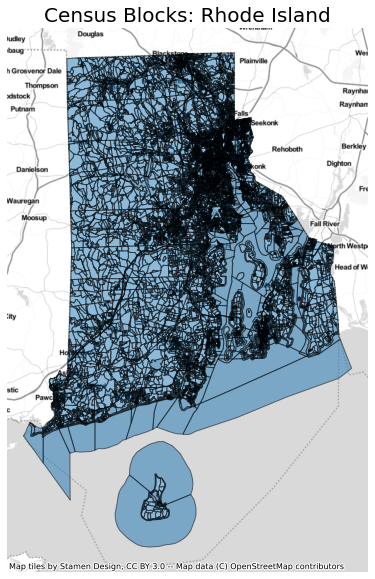

In [6]:
ax = ri.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Census Blocks: Rhode Island",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Both the geo and population tables use `GEOID` as a unique identifier, so the geometries and population data can be joined together. Remember that population data are not available for territories, so we'll use an inner join.

In [7]:
df = geo.join(pop[["P0010001"]], how="inner")
ri = df.loc[start:stop].compute()
ri.head()

STATEFP COUNTYFP  TRACTCE  BLOCKCE  ALAND  AWATER   INTPTLAT  \
GEOID                                                                          
440010301001000      44      001    30100     1000   5329       0  41.765149   
440010301001001      44      001    30100     1001   6001       0  41.765003   
440010301001002      44      001    30100     1002  11821       0  41.764453   
440010301001003      44      001    30100     1003  16049       0  41.763871   
440010301001004      44      001    30100     1004   5398       0  41.764249   

                  INTPTLON                                           geometry  \
GEOID                                                                           
440010301001000 -71.333153  POLYGON ((-71.33394 41.76482, -71.33266 41.765...   
440010301001001 -71.332271  POLYGON ((-71.33301 41.76503, -71.33235 41.765...   
440010301001002 -71.332507  POLYGON ((-71.33343 41.76474, -71.33324 41.764...   
440010301001003 -71.332863  POLYGON ((-71.33430 41.76413, -71.33410 41.764...   
440010301001004 -71.334446  POLYGON ((-71.33524 41.76393, -71.33394 41.764...   

                 P0010001  
GEOID                      
440010301001000        19  
440010301001001        12  
440010301001002        25  
440010301001003        36  
440010301001004        25

Now lets plot the census blocks in Providence County with at least 150 people.

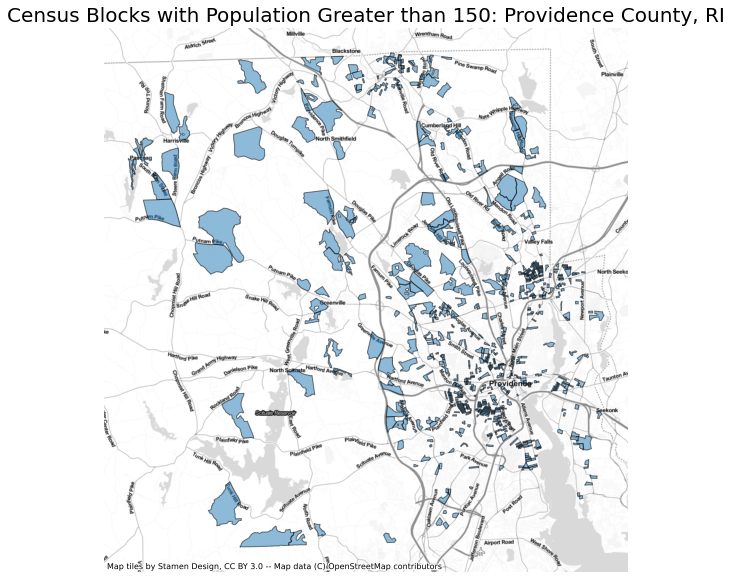

In [8]:
providence = ri[(ri.P0010001 >= 150) & (ri.COUNTYFP == "007")]

ax = providence.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Census Blocks with Population Greater than 150: Providence County, RI",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

You can use this method with any census block within any county in the US.

**[Jump to Top](#United-States-2020-Census-data)**

### Census data by cartographic boundaries

The second block of data is organized by different cartographic categories. These boundaries cover larger areas than the individual census blocks discussed [above](#Census-data-by-census-block-boundaries). The different categories range from census block groups (consisting of several census blocks) all the way up to a National Boundary file (encompassing the entire USA).

The files in this second group tend to be smaller in size than the census block data in the first group. Therefore, the files in the second group are not partitioned into multiple files, and each dataset only consists of one parquet file. Another difference is that the datasets in this second group include different information than the census block files in the first group and do not contain population statistics. Which additional data is included differs from dataset to dataset. See [Appendix E. in the 2020 TIGER/Line Technical Documentation](https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2020/TGRSHP2020_TechDoc.pdf) for more details on the available feature classes.

The following sections are examples of how to access and view each cartographic boundary file in this second group of data. Each example uses the same basic workflow and dependencies as the [Census Block Boundaries](#Census-data-by-census-block-boundaries) for the first group of data. An important thing to note when using this data is that before plotting the data onto a basemap, the datasets need to be converted to Web Mercator [(EPSG 3857)](https://epsg.io/3857) using the [to_crs](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) function of [GeoPandas](https://geopandas.org/).

Some of the datasets are grouped together based on their type. It is important to note that some of the files may have gaps where no relevant data exists because states with no Tribal Block Groups do not have any Tribal Block Group data. The header for each example also includes the relevant abbreviation used for data access and retrieval.

### American Indian Area Geographies

American Indian Area Geographies is the first grouping of cartographic boundary files available.

#### American Indian/Alaska Native Areas/Hawaiian Home Lands (AIANNH)

This file contains data for legal and statistical [American Indian/Alaska Native Areas/Hawaiian Home Lands (AIANNH)](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_1) entities published by the US Census Bureau.

The attribute table contains the following information:

* AIANNHCE = AIANNH census code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = concatenation of AIANNH census code and reservation/statistical area or off-reservation trust land Hawaiian home land indicator
* NAME = Current Area Name
* NAMELSAD = Current name and legal/statistical status for each entity
* LSAD = Current legal/statistical area code
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for AIANNH polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the AIANNH data from the parquet file of the Planetary Computer dataset:

In [9]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_aiannh_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

AIANNHCE  AIANNHNS       AFFGEOID GEOID                NAME  \
0      9515   2418775  2500000US9515  9515      Apache Choctaw   
1      9370    979494  2500000US9370  9370          Shinnecock   
2      9820   2418693  2500000US9820  9820  MaChis Lower Creek   
3      6125   2418774  2500000US6125  6125               Anvik   
4      6350   2418836  2500000US6350  6350              Circle   

                         NAMELSAD LSAD       ALAND   AWATER  \
0            Apache Choctaw SDTSA   92   221751364  2632531   
1  Shinnecock (state) Reservation   86     3494292        0   
2        MaChis Lower Creek SDTSA   92  1680767035  6816074   
3                     Anvik ANVSA   79    24578643  6308736   
4                    Circle ANVSA   79   274634016  1398608   

                                            geometry  
0  POLYGON ((-93.77547 31.61937, -93.77411 31.619...  
1  POLYGON ((-72.44070 40.87749, -72.43870 40.879...  
2  MULTIPOLYGON (((-85.54654 31.21440, -85.54342 ...  
3  POLYGON ((-160.24545 62.69478, -160.24517 62.6...  
4  POLYGON ((-144.38284 65.73496, -144.37907 65.7...

Next, plot the data from this parquet file and apply a basemap. Rather than displaying the whole dataset, show only the Apache Choctaw American Indian Homeland by selecting a subset of the dataframe where the values in the `NAME` column match `"Apache Choctaw"`.

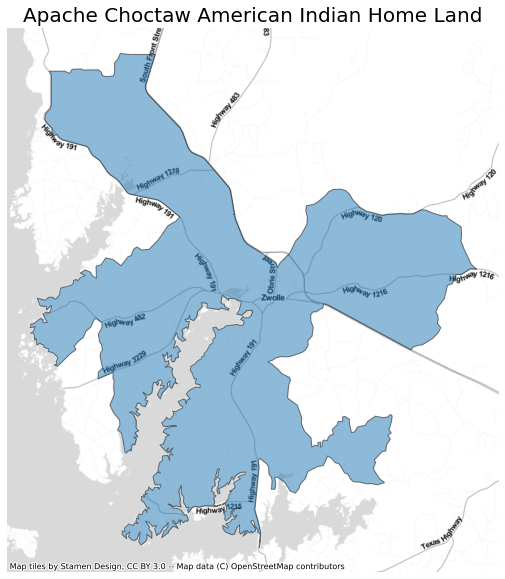

In [10]:
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME == "Apache Choctaw"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Apache Choctaw American Indian Home Land",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

This map shows the shape of the Apache Choctaw American Indian Homeland overlayed on a Stamen Terrain Style basemap. To display the entire dataset, remove the part of the code that limits the dataframe to only the Apache Choctaw homeland. To plot a different area, change the dataframe's filter to a different attribute or value.

**[Jump to Top](#United-States-2020-Census-data)**

#### American Indian Tribal Subdivisions (AITSN)

This file contains data on [American Indian Tribal Subdivisions](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_1). These areas are the legally defined subdivisions of American Indian Reservations (AIR), Oklahoma Tribal Statistical Areas (OTSA), and Off-Reservation Trust Land (ORTL).

The attribute table contains the following information:

* AIANNHCE = AIANNH census code
* TRSUBCE = Current AITSN census code
* TRSUBNS = ANSI feature code for American Indian Tribal Subdivision
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = concatenation of AIANNH census code and AITSN census code
* NAME = Current Area Name
* NAMELSAD = Current name and legal/statistical AITSN description
* LSAD = Current legal/statistical area code
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for AITSN polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the AIANNH data from the parquet file of the Planetary Computer dataset:

In [11]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_aitsn_500k").assets["data"]
)

ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

AIANNHCE  TRSUBCE  TRSUBNS          AFFGEOID    GEOID        NAME  \
0       335      100  2418904  2510000US0335100  0335100  Deer Creek   
1      1150      400  2418959  2510000US1150400  1150400        Hays   
2      1160      300  2419007  2510000US1160300  1160300    Mandaree   
3      5590      750  2418886  2510000US5590750  5590750          10   
4      5590      150  2418889  2510000US5590150  5590150           2   

             NAMELSAD LSAD       ALAND     AWATER  \
0  Deer Creek Segment   T3    91039385    1744201   
1       Hays District   07   795597488    2961386   
2    Mandaree Segment   T3   919294747  148670196   
3  County District 10   TC  3302876506   41402950   
4   County District 2   TC  2166517795   72598055   

                                            geometry  
0  POLYGON ((-93.59601 47.89783, -93.57287 47.898...  
1  MULTIPOLYGON (((-108.90981 47.91399, -108.8883...  
2  POLYGON ((-102.78425 47.67410, -102.78497 47.7...  
3  POLYGON ((-96.45392 34.19828, -96.45372 34.257...  
4  POLYGON ((-95.04677 34.41936, -95.00595 34.419...

Next, plot the data from this parquet file and overlay it on a basemap.

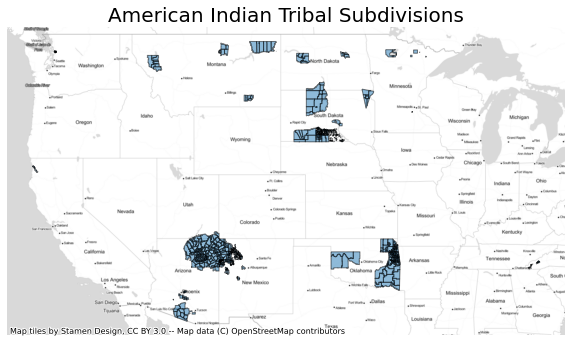

In [12]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "American Indian Tribal Subdivisions",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows all the American Indian Tribal Subdivisions.

**[Jump to Top](#United-States-2020-Census-data)**

#### Alaska Native Regional Corporations (ANRC)

This file contains data on [Alaska Native Regional Corporations](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_1), which are corporations created according to the Alaska Native Claims Settlement Act. 

The attribute table contains the following information:

* STATEFP = State FIPS code
* ANRCFP = ANRC FIPS code
* ANRCNS = ANSI feature code for Alaska Native Regional Corporation
* AFFGEOID American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = concatenation of state FIPS code and ANRC FIPS Code
* NAME = Current area name
* NAMELSAD = Current name and legal/statistical area description
* LSAD = Legal/statistical area description code
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for ANRC polygon

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the ANRC data from the parquet file of the Planetary Computer dataset:

In [13]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_02_anrc_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP  ANRCFP   ANRCNS          AFFGEOID    GEOID         NAME  \
0      02    9040  2419321  2300000US0209040  0209040  Bristol Bay   
1      02     590  2419295  2300000US0200590  0200590        Ahtna   
2      02   67940  2419136  2300000US0267940  0267940     Sealaska   
3      02   17140  2418878  2300000US0217140  0217140   Cook Inlet   
4      02    9800  2419328  2300000US0209800  0209800      Calista   

                                         NAMELSAD LSAD         ALAND  \
0  Bristol Bay Alaska Native Regional Corporation   77  104110270640   
1        Ahtna Alaska Native Regional Corporation   77   74027413736   
2     Sealaska Alaska Native Regional Corporation   77   91073660613   
3   Cook Inlet Alaska Native Regional Corporation   77   96361403418   
4      Calista Alaska Native Regional Corporation   77  142464876475   

        AWATER                                           geometry  
0  25993444733  MULTIPOLYGON (((-158.15947 56.14452, -158.1537...  
1   1391256190  POLYGON ((-149.38382 63.35746, -148.96463 63.4...  
2  41754708205  MULTIPOLYGON (((-132.09854 56.07761, -132.0974...  
3  20418982039  MULTIPOLYGON (((-150.28586 61.12704, -150.2808...  
4  19389800572  MULTIPOLYGON (((-161.67073 58.56075, -161.6672...

Next, plot the data from this parquet file and overlay it on a basemap. To make the data work better with the Mercator Projection, exclude part of the dataset from the plot. To do so, limit your dataframe to rows that do not include `"Aleut"` in the AIANNHCE column.

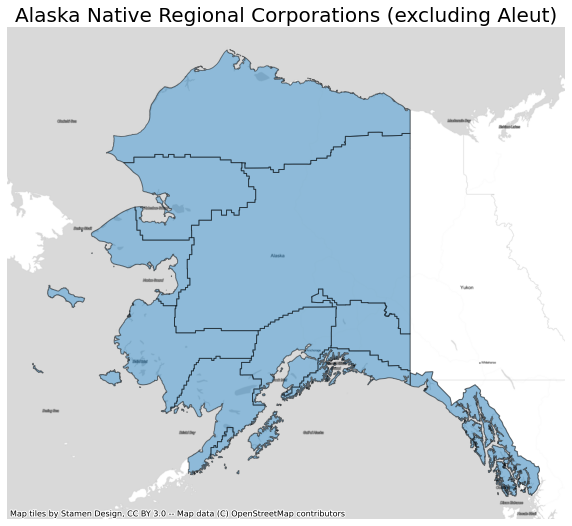

In [14]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME != "Aleut"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Alaska Native Regional Corporations (excluding Aleut)",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows all the Alaskan Native Regional Corporations except for Aleut.

**[Jump to Top](#United-States-2020-Census-data)**

#### Tribal Block Groups (TBG)

This file includes data on [Tribal Block Groups](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_26), which are subdivisions of Tribal Census Tracts. These block groups can extend over multiple AIRs and ORTLs due to areas not meeting Block Group minimum population thresholds.

The attribute table contains the following information:

* AIANNHCE = AIANNH census code
* TTRACTCE = Tribal Census Tract Code
* TBLKGPCE = Tribal Block Group letter
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = concatenation of AIANNH census code, trival census tract code, and tribal block group letter
* NAMELSAD = Current legal/statistical description and tribal block group letter
* LSAD = Current legal/statistical area code
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Block Group polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Tribal Block Group data from the parquet file of the Planetary Computer dataset:

In [15]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_tbg_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

AIANNHCE TTRACTCE TBLKGPCE              AFFGEOID        GEOID  \
0      2430   T03700        C  2580000US2430T03700C  2430T03700C   
1        20   T00400        B  2580000US0020T00400B  0020T00400B   
2      1150   T00100        C  2580000US1150T00100C  1150T00100C   
3      2555   T01000        A  2580000US2555T01000A  2555T01000A   
4       275   T00100        A  2580000US0275T00100A  0275T00100A   

               NAMELSAD LSAD      ALAND   AWATER  \
0  Tribal Block Group C   IB    3945195        0   
1  Tribal Block Group B   IB    1200584   100165   
2  Tribal Block Group C   IB  654354613  2911122   
3  Tribal Block Group A   IB   39634390  4216784   
4  Tribal Block Group A   IB     482651        0   

                                            geometry  
0  POLYGON ((-111.26008 36.10715, -111.25910 36.1...  
1  POLYGON ((-116.47052 33.78691, -116.46940 33.7...  
2  MULTIPOLYGON (((-108.90981 47.91399, -108.8883...  
3  POLYGON ((-75.91155 43.00678, -75.90228 43.006...  
4  POLYGON ((-122.88954 39.02367, -122.88639 39.0...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select only data for Tribal Block Group A by filtering by the TBLKGPCE column. Due to block group population threshold minimums, Tribal Block Group A spans a large portion of the contiguous United States and is not fully connected.

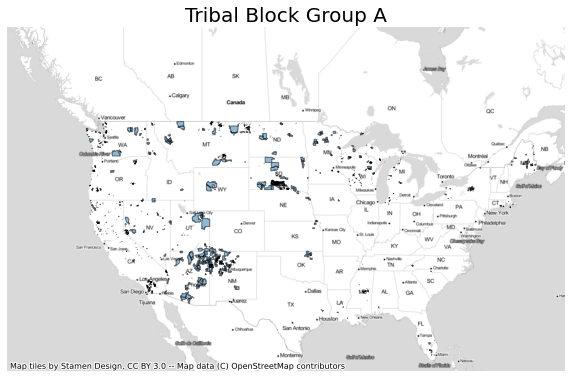

In [16]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.TBLKGPCE == "A"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Tribal Block Group A",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Tribal Block Group A.

**[Jump to Top](#United-States-2020-Census-data)**

#### Tribal Census Tracts (TTRACT)

This file includes data on [Tribal Census Tracts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_27) which are relatively small statistical subdivisions of AIRs and ORTLs defined by federally recognized tribal government officials in partnership with the Census Bureau. Due to population thresholds, the Tracts may consist of multiple non-contiguous areas.

The attribute table contains the following information:

* AIANNHCE = AIANNH census code
* TTRACTCE = Tribal Census Tract Code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = concatenation of AIANNH census code and tribal census tract code
* NAME = Tribal Census Tract name
* NAMELSAD = Current legal/statistical description and tribal census tract name
* LSAD = Current legal/statistical area code
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Tribal Census Tract polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Tribal Block Group data from the parquet file of the Planetary Computer dataset:

In [17]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_ttract_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

AIANNHCE TTRACTCE             AFFGEOID       GEOID  NAME  \
0       990   T00100  2560000US0990T00100  0990T00100  T001   
1      3935   T00100  2560000US3935T00100  3935T00100  T001   
2      1160   T00200  2560000US1160T00200  1160T00200  T002   
3       525   T00100  2560000US0525T00100  0525T00100  T001   
4      4390   T00100  2560000US4390T00100  4390T00100  T001   

                   NAMELSAD LSAD       ALAND     AWATER  \
0  Tribal Census Tract T001   IT   134672514      47477   
1  Tribal Census Tract T001   IT   614259770   20267661   
2  Tribal Census Tract T002   IT  1955706500  421434881   
3  Tribal Census Tract T001   IT     4176988          0   
4  Tribal Census Tract T001   IT  1612375179    5684784   

                                            geometry  
0  MULTIPOLYGON (((-83.38715 35.46808, -83.38610 ...  
1  MULTIPOLYGON (((-98.76648 48.00405, -98.76471 ...  
2  POLYGON ((-102.65466 47.87091, -102.65497 47.8...  
3  MULTIPOLYGON (((-80.89902 34.90259, -80.89470 ...  
4  POLYGON ((-110.53722 40.44993, -110.53444 40.4...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select only data for Tribal Census Tract T002 by filtering by the NAME column. Due to census tract population threshold minimums, Tribal Census Tract T002 spans a large portion of the contiguous United States and is not fully connected.

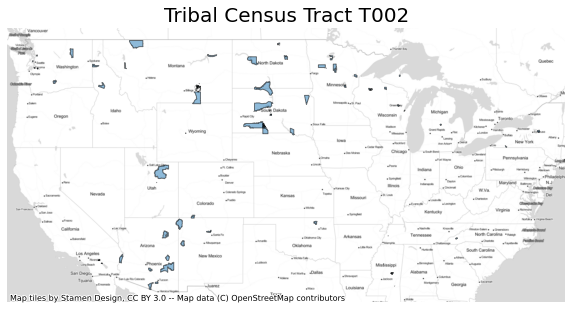

In [18]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME == "T002"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Tribal Census Tract T002",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Tribal Census Tract T002.

**[Jump to Top](#United-States-2020-Census-data)**

### Census Block Groups (BG)

This file contains data on [Census Block Groups](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_4). These groups are the second smallest geographic grouping. They consist of clusters of blocks within the same census tract that share the same first digit of their 4-character census block number. Census Block Groups generally contain between 600 and 3,000 people and generally cover contiguous areas.

The attribute table contains the following information:

* STATEFP = State FIPS code
* COUNTYFP = County FIPS code
* TRACTCE = Census tract code
* BLKGRPCE = Block group number
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS, County FIPS, Census tract code, and block group number
* NAME = Block group number
* NAMELSAD = Legal/statistical description and group number
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Block Group polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Block Group data from the parquet file of the Planetary Computer dataset:

In [19]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_bg_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP COUNTYFP  TRACTCE BLKGRPCE               AFFGEOID         GEOID  \
0      36      029     4200        2  1500000US360290042002  360290042002   
1      36      061    12400        8  1500000US360610124008  360610124008   
2      36      059   410400        4  1500000US360594104004  360594104004   
3      36      047   118800        2  1500000US360471188002  360471188002   
4      36      005    12500        1  1500000US360050125001  360050125001   

  NAME       NAMELSAD LSAD   ALAND  AWATER  \
0    2  Block Group 2   BG  168802       0   
1    8  Block Group 8   BG   18510       0   
2    4  Block Group 4   BG  305990       0   
3    2  Block Group 2   BG   52033       0   
4    1  Block Group 1   BG  100794       0   

                                            geometry  
0  POLYGON ((-78.81870 42.93591, -78.81814 42.936...  
1  POLYGON ((-73.95425 40.76617, -73.95203 40.765...  
2  POLYGON ((-73.72361 40.66781, -73.72217 40.672...  
3  POLYGON ((-73.86754 40.68043, -73.86575 40.680...  
4  POLYGON ((-73.89529 40.82814, -73.89506 40.828...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select only data for the state of California by filtering by the State FIPS code (`"06"`) in the STATEFP column.

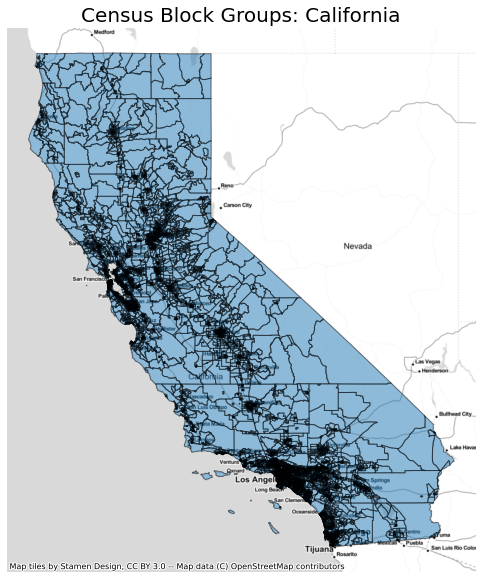

In [20]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.STATEFP == "06"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Census Block Groups: California",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows all the Census Block Groups in California.

**[Jump to Top](#United-States-2020-Census-data)**

### Census Tracts (TRACT)

This file contains data on [Census Tracts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_13) which are small and relatively permanent statistical subdivisions of a county or equivalent entity. Tract population size is generally between 1,200 and 8,000 people with an ideal size of 4,000. Boundaries tend to follow visible and identifiable features and are usually contiguous areas.

The attribute table contains the following information:

* STATEFP = State FIPS code
* COUNTYFP = County FIPS code
* TRACTCE = Census tract code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS, County FIPS, and Census tract code
* NAME = Census Tract name, it is the census tract code converted to an integer
* NAMELSAD = Legal/statistical description and tract name
* STUSPS = FIPS State Postal Code
* NAMELSADCO = County name
* STATE_NAME = State Name
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Census Tract polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Census Tract data from the parquet file of the Planetary Computer dataset:

In [21]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_tract_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP COUNTYFP  TRACTCE              AFFGEOID        GEOID     NAME  \
0      17      089   853004  1400000US17089853004  17089853004  8530.04   
1      11      001     5003  1400000US11001005003  11001005003    50.03   
2      06      037   482503  1400000US06037482503  06037482503  4825.03   
3      31      153    10630  1400000US31153010630  31153010630   106.30   
4      12      057    13706  1400000US12057013706  12057013706   137.06   

               NAMELSAD STUSPS            NAMELSADCO            STATE_NAME  \
0  Census Tract 8530.04     IL           Kane County              Illinois   
1    Census Tract 50.03     DC  District of Columbia  District of Columbia   
2  Census Tract 4825.03     CA    Los Angeles County            California   
3   Census Tract 106.30     NE          Sarpy County              Nebraska   
4   Census Tract 137.06     FL   Hillsborough County               Florida   

  LSAD    ALAND  AWATER                                           geometry  
0   CT  3622334   91650  POLYGON ((-88.35003 41.80764, -88.34938 41.810...  
1   CT    94136       0  POLYGON ((-77.03195 38.90965, -77.03032 38.909...  
2   CT   729678       0  POLYGON ((-118.09949 34.06262, -118.09466 34.0...  
3   CT  4964876       0  POLYGON ((-96.23429 41.19035, -96.23010 41.190...  
4   CT   535141   10298  POLYGON ((-82.34769 27.89656, -82.34680 27.898...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select only data for Census Tracts located in Washington, DC by filtering for `"DC"` in the STUSPS column.

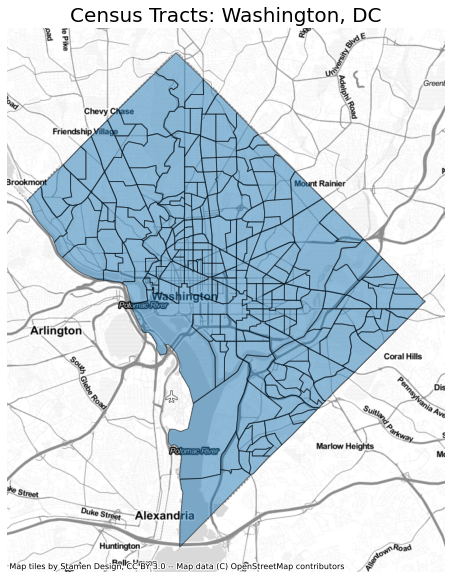

In [22]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.STUSPS == "DC"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Census Tracts: Washington, DC",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows all the Census Tracts in Washington, DC.

**[Jump to Top](#United-States-2020-Census-data)**

### Congressional Districts: 116th Congress (CD116)

This file contains data on the [Congressional Districts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_9) for the 116th Congress. 

The attribute table contains the following information:

* STATEFP = State FIPS Code
* CD116FP = Congressional District FIPS code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS and congressional district FIPS code
* NAMELSAD = Legal/statistical description and name
* LSAD = Legal/statistical classification
* CDSESSN = Congressional Session Code
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Congressional District polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Congressional District data from the parquet file of the Planetary Computer dataset:

In [23]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_cd116_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP  CD116FP       AFFGEOID GEOID                   NAMELSAD LSAD  \
0      06       42  5001600US0642  0642  Congressional District 42   C2   
1      39        7  5001600US3907  3907   Congressional District 7   C2   
2      48        3  5001600US4803  4803   Congressional District 3   C2   
3      28        2  5001600US2802  2802   Congressional District 2   C2   
4      42       18  5001600US4218  4218  Congressional District 18   C2   

   CDSESSN        ALAND     AWATER  \
0      116   2424753563   44105315   
1      116  10010016396   64562455   
2      116   1245574011   97890112   
3      116  40278711117  951654563   
4      116    757655195   19985421   

                                            geometry  
0  POLYGON ((-117.67629 33.88882, -117.65488 33.8...  
1  MULTIPOLYGON (((-82.55933 40.78975, -82.55835 ...  
2  POLYGON ((-96.84410 32.98891, -96.84403 32.992...  
3  POLYGON ((-91.36371 31.78036, -91.35951 31.799...  
4  POLYGON ((-80.17834 40.33725, -80.17537 40.338...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select only data for Maryland"s 2nd Congressional District by filtering by the State FIPS code `24` and the Congressional District FIPS code `02` in the GEOID column.

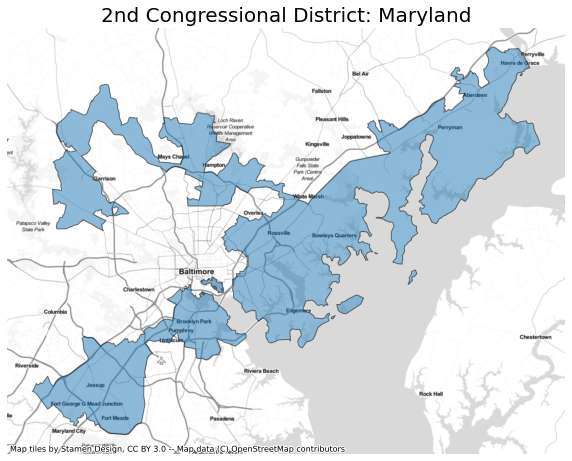

In [24]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.GEOID == "2402"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "2nd Congressional District: Maryland",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Maryland"s 2nd Congressional District.

**[Jump to Top](#United-States-2020-Census-data)**

### Consolidated Cities (CONCITY)

This file contains data on [Consolidated Cities](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_8). These are areas where one or several other incorporated places in a county or Minor Civil Division are included in a consolidated government but still exist as separate legal entities.

The attribute table contains the following information:

* STATEFP = State FIPS Code
* CONCTYFP = Consolidated city FIPS code
* CONCTYNS = Consolidated city GNIS code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS and consolidated city FIPS code
* NAME = Consolidated city name
* NAMELSAD = Name and Legal/statistical description
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Consolidated City polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Consolidated City data from the parquet file of the Planetary Computer dataset:

In [25]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_concity_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP  CONCTYFP  CONCTYNS          AFFGEOID    GEOID  \
0      20     28410   2664357  1700000US2028410  2028410   
1      13      3436   2407404  1700000US1303436  1303436   
2      30     11390   2409651  1700000US3011390  3011390   
3      21     48003   1967435  1700000US2148003  2148003   
4      09     47500   2378334  1700000US0947500  0947500   

                          NAME                                      NAMELSAD  \
0               Greeley County             Greeley County unified government   
1         Athens-Clarke County       Athens-Clarke County unified government   
2             Butte-Silver Bow                              Butte-Silver Bow   
3  Louisville/Jefferson County  Louisville/Jefferson County metro government   
4                      Milford                                  Milford city   

  LSAD       ALAND    AWATER  \
0   UG  2015424640         0   
1   UG   308784927   4688313   
2   00  1859568271   1518178   
3   MT   986271740  43513298   
4   25    57444044  10216676   

                                            geometry  
0  POLYGON ((-102.04526 38.50540, -102.04526 38.5...  
1  POLYGON ((-83.53739 33.96591, -83.49824 33.987...  
2  POLYGON ((-113.08552 45.86065, -113.08282 45.8...  
3  POLYGON ((-85.94711 38.00509, -85.94222 38.007...  
4  POLYGON ((-73.12245 41.18290, -73.12137 41.187...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select only data for Athens-Clarke County, GA, which is a Consolidated City. Select the data by filtering by the NAME  column.

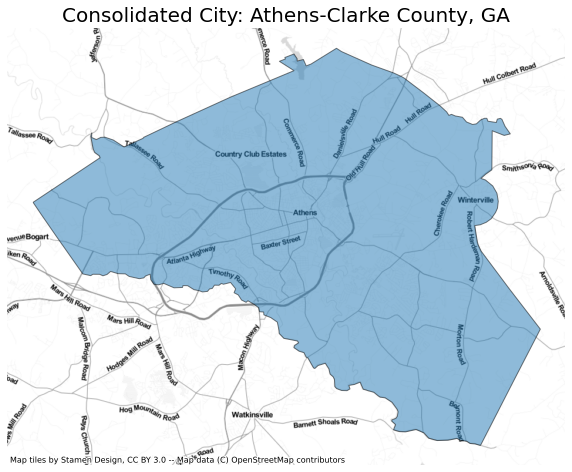

In [26]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME == "Athens-Clarke County"].plot(
    figsize=(10, 10), alpha=0.5, edgecolor="k"
)
ax.set_title(
    "Consolidated City: Athens-Clarke County, GA",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Athens-Clarke County, GA.

**[Jump to Top](#United-States-2020-Census-data)**

### Counties (COUNTY)

This file contains data on [Counties and Equivalent Entities](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_12). These are the primary legal divisions of states. Most states use the term "counties," but other terms such as "Parishes," "Municipios," or "Independent Cities" may be used. 

The attribute table contains the following information:

* STATEFP = State FIPS Code
* COUNTYFP = County FIPS code
* COUNTNS = ANSI feature code for the county
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS and county FIPS code
* NAME = County name
* NAMELSAD = Name and Legal/statistical description
* STUSPS = FIPS State Postal Code
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for County polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Counties and Equivalent Entities data from the parquet file of the Planetary Computer dataset:

In [27]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_county_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID       NAME  \
0      21      141  00516917  0500000US21141  21141      Logan   
1      36      081  00974139  0500000US36081  36081     Queens   
2      34      017  00882278  0500000US34017  34017     Hudson   
3      34      019  00882228  0500000US34019  34019  Hunterdon   
4      21      147  00516926  0500000US21147  21147   McCreary   

           NAMELSAD STUSPS  STATE_NAME LSAD       ALAND     AWATER  \
0      Logan County     KY    Kentucky   06  1430224002   12479211   
1     Queens County     NY    New York   06   281594050  188444349   
2     Hudson County     NJ  New Jersey   06   119640822   41836491   
3  Hunterdon County     NJ  New Jersey   06  1108086284   24761598   
4   McCreary County     KY    Kentucky   06  1105416696   10730402   

                                            geometry  
0  POLYGON ((-87.06037 36.68085, -87.06002 36.708...  
1  POLYGON ((-73.96262 40.73903, -73.96243 40.739...  
2  MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...  
3  POLYGON ((-75.19511 40.57969, -75.19466 40.581...  
4  POLYGON ((-84.77845 36.60329, -84.73068 36.665...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select only data for counties in Minnesota by filtering by the STATE_NAME column.

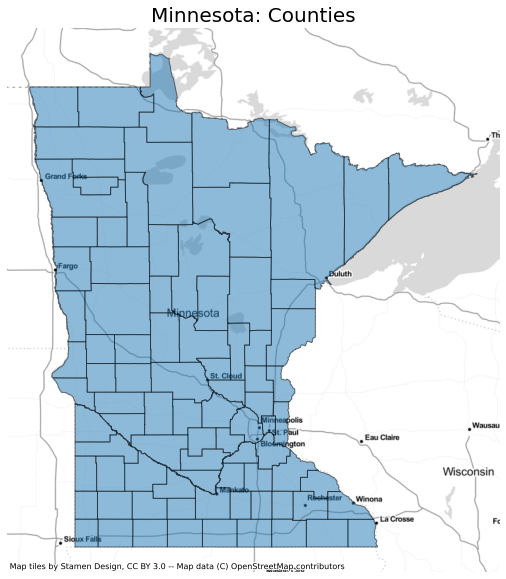

In [28]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.STATE_NAME == "Minnesota"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Minnesota: Counties",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Minnesota Counties.

**[Jump to Top](#United-States-2020-Census-data)**

### Counties within Congressional Districts: 116th Congress (COUNTY_within_CD116)

This file contains data on Counties within Congressional Districts.

The attribute PARTFLG identifies whether all or only part of a County is within a Congressional District:

* N = All of a County is within a Congressional District
* Y = only part of a county is within a Congressional District

The attribute table contains the following information:

* STATEFP = State FIPS code
* COUNTYFP = County FIPS code
* CD116FP = Congressional District FIPS code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS, Congressional District FIPS, and county FIPS code
* PARTFLD = Identifies if all or part of entity is within the file
* ALAND = Current Land Area
* geometry = coordinates for polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Counties within Congressional Districts data from the parquet file of the Planetary Computer dataset:

In [29]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_county_within_cd116_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP COUNTYFP  CD116FP          AFFGEOID    GEOID PARTFLG        ALAND  \
0      05      057        4  5101600US0504057  0504057       N   1883438547   
1      54      037        2  5101600US5402037  5402037       N    542072983   
2      02      170        0  5101600US0200170  0200170       N  63990747114   
3      54      013        2  5101600US5402013  5402013       N    723253605   
4      12      077        2  5101600US1202077  1202077       N   2164099094   

                                            geometry  
0  POLYGON ((-93.96945 33.74021, -93.96842 33.741...  
1  POLYGON ((-78.03545 39.27822, -78.03326 39.279...  
2  POLYGON ((-153.00188 62.72583, -152.99961 62.7...  
3  POLYGON ((-81.27841 38.91487, -81.27417 38.918...  
4  POLYGON ((-85.15381 30.09285, -85.15185 30.094...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select only polygons where only part of the County is within a Congressional District. Select the relevant data by filtering by `"Y"` in the PARTFLG column.

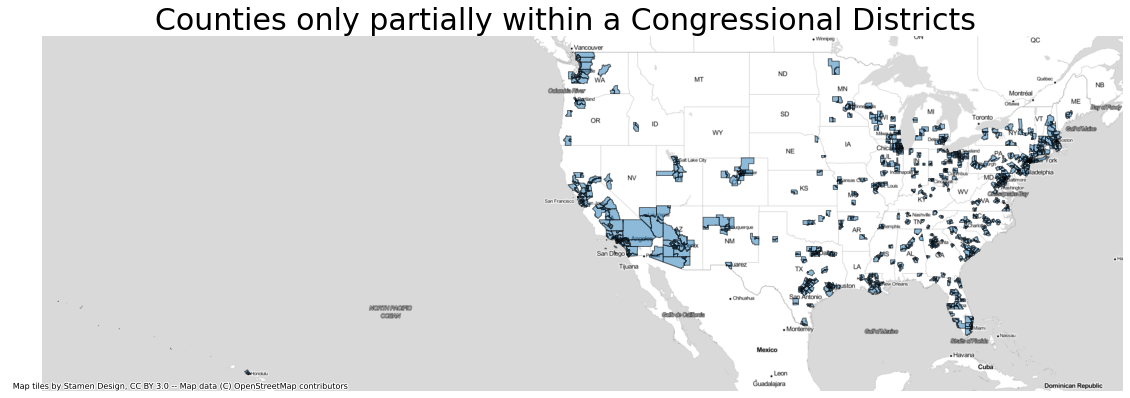

In [30]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.PARTFLG == "Y"].plot(figsize=(20, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Counties only partially within a Congressional Districts",
    fontdict={"fontsize": "30", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Counties partially within Congressional Districts.

**[Jump to Top](#United-States-2020-Census-data)**

### County Subdivisions (COUSUB)

This file contains [County Subdivisions](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_11), which are the primary divisions of counties and equivalent entities. These divisions vary from state to state and include Barrios, Purchases, Townships, and other types of legal and statistical entities. 

The attribute table contains the following information:

* STATEFP = State FIPS code
* COUNTYFP = County FIPS code
* COUSUBFP = Subdivision FIPS code
* COUSUBNS = ANSI feature for the subdivision
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS, county FIPS, and county subdivision FIPS
* NAME = Subdivision name
* NAMELSAD = Subdivision name and legal/statistical description
* STUSPS = FIPS State Postal Code
* NAMELSADCO = County name
* STATE_NAME = State Name
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for County Subdivision polygons


Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the County Subdivisions data from the parquet file of the Planetary Computer dataset:

In [31]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_cousub_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP COUNTYFP COUSUBFP  COUSUBNS             AFFGEOID       GEOID  \
0      42      117    52960  01217118  0600000US4211752960  4211752960   
1      46      109    42820  01268550  0600000US4610942820  4610942820   
2      46      083    20780  01267387  0600000US4608320780  4608320780   
3      47      009    91340  02464659  0600000US4700991340  4700991340   
4      48      489    93435  01939169  0600000US4848993435  4848993435   

          NAME            NAMELSAD STUSPS      NAMELSADCO    STATE_NAME LSAD  \
0       Nelson     Nelson township     PA    Tioga County  Pennsylvania   44   
1    Minnesota  Minnesota township     SD  Roberts County  South Dakota   44   
2     Fairview       Fairview town     SD  Lincoln County  South Dakota   43   
3            8          District 8     TN   Blount County     Tennessee   28   
4  San Perlita     San Perlita CCD     TX  Willacy County         Texas   22   

       ALAND     AWATER                                           geometry  
0   29020811      25916  POLYGON ((-77.31788 41.97075, -77.31029 41.970...  
1  121465694    3383863  POLYGON ((-97.10387 45.90342, -97.10309 45.908...  
2     221380          0  POLYGON ((-96.49153 43.22389, -96.48526 43.224...  
3  646087619     509512  POLYGON ((-83.99881 35.55556, -83.99444 35.558...  
4  739156645  483409952  MULTIPOLYGON (((-97.25810 26.42544, -97.25596 ...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, plot all the subdivisions, townships in this case, in Bergen County, NJ. Select the relevant data by filtering by the NAMELSADCO column.

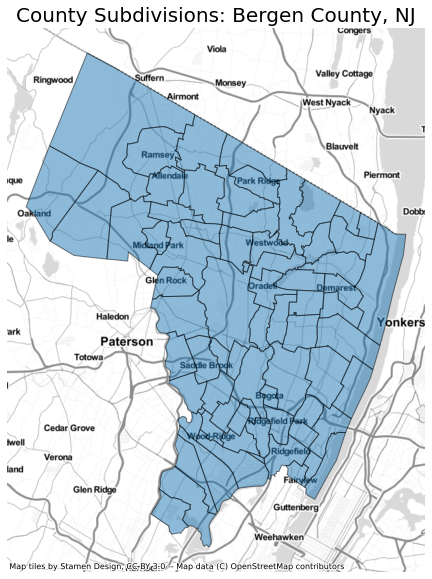

In [32]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAMELSADCO == "Bergen County"].plot(
    figsize=(10, 10), alpha=0.5, edgecolor="k"
)
ax.set_title(
    "County Subdivisions: Bergen County, NJ",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows County Subdivisions in Bergen County, NJ.

**[Jump to Top](#United-States-2020-Census-data)**

### Divisions (DIVISION)

This file contains data on [Divisions](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_10) of the US. This file is similar to the Regions file but contains more divisions and encompasses several states per division.

The attribute table contains the following information:

* DIVISIONCE = Number assigned to each division
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = DIVISIONCE
* NAME = Name of division
* NAMELSAD = Division name and legal/statistical description
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Division polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Division data from the parquet file of the Planetary Computer dataset:

In [33]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_division_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

DIVISIONCE    AFFGEOID GEOID                NAME  \
0           5  0300000US5     5      South Atlantic   
1           3  0300000US3     3  East North Central   
2           4  0300000US4     4  West North Central   
3           8  0300000US8     8            Mountain   
4           9  0300000US9     9             Pacific   

                      NAMELSAD LSAD          ALAND        AWATER  \
0      South Atlantic Division   69   687125298338   86339601557   
1  East North Central Division   69   629298010339  151248789139   
2  West North Central Division   69  1314700010733   33034200327   
3            Mountain Division   69  2217352931824   19266522413   
4             Pacific Division   69  2319992840165  296172644163   

                                            geometry  
0  MULTIPOLYGON (((-75.56555 39.51485, -75.56174 ...  
1  MULTIPOLYGON (((-82.73447 41.60351, -82.72425 ...  
2  MULTIPOLYGON (((-89.59206 47.96668, -89.59147 ...  
3  POLYGON ((-120.00574 39.22866, -120.00567 39.2...  
4  MULTIPOLYGON (((-139.51201 59.70289, -139.5095...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select only data from the Mountain division by filtering by the NAME column.

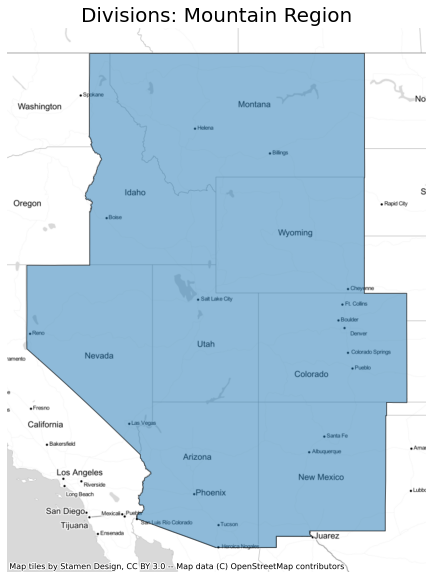

In [34]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME == "Mountain"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Divisions: Mountain Region",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the Mountain Region Division.

**[Jump to Top](#United-States-2020-Census-data)**

### Metropolitan and Micropolitan Statistical Areas and Related Statistical Areas

[Metropolitan and Micropolitan Statistical Areas and Related Statistical Areas](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_7) is the second grouping of datasets within the census data by cartographic boundaries group. A metropolitan or micropolitan statistical area contains a core area, with a substantial population with adjacent communities having a high degree of economic and social integration with that core. This grouping contains six datasets.

#### Core Based Statistical Areas (CBSAs)

This file contains data on [Core Based Statistical Areas (CBSAs)](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_7). This encompasses all metropolitan and micropolitan statistical areas.

The attribute table contains the following information:

* CSAFP = Combined statistical area code (if applicable)
* CBSAFP = Metropolitan statistical area/micropolitan statistical area code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = CBSAFP
* NAME = Metropolitan statistical area/micropolitan statistical area name
* NAMELSAD = CBSA name and legal/statistical description
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for CBSA polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the CBSA data from the parquet file of the Planetary Computer dataset:

In [35]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_cbsa_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

CSAFP  CBSAFP        AFFGEOID  GEOID            NAME  \
0   <NA>   11380  310M600US11380  11380     Andrews, TX   
1    192   35140  310M600US35140  35140    Newberry, SC   
2   <NA>   37540  310M600US37540  37540       Paris, TN   
3    246   29900  310M600US29900  29900  Laurinburg, NC   
4    315   35460  310M600US35460  35460     Newport, TN   

                    NAMELSAD LSAD       ALAND    AWATER  \
0     Andrews, TX Micro Area   M2  3886850259    957039   
1    Newberry, SC Micro Area   M2  1632452022  44011454   
2       Paris, TN Micro Area   M2  1455320362  81582236   
3  Laurinburg, NC Micro Area   M2   826569986   3842049   
4     Newport, TN Micro Area   M2  1129584563  17932684   

                                            geometry  
0  POLYGON ((-103.06470 32.52219, -103.00047 32.5...  
1  POLYGON ((-81.94372 34.20605, -81.94196 34.208...  
2  POLYGON ((-88.52940 36.17018, -88.52636 36.229...  
3  POLYGON ((-79.69251 34.80685, -79.68822 34.809...  
4  POLYGON ((-83.31519 35.89332, -83.31078 35.895...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select Kahului-Wailuku-Lahaina, HI Metro Area by filtering by the NAME column.

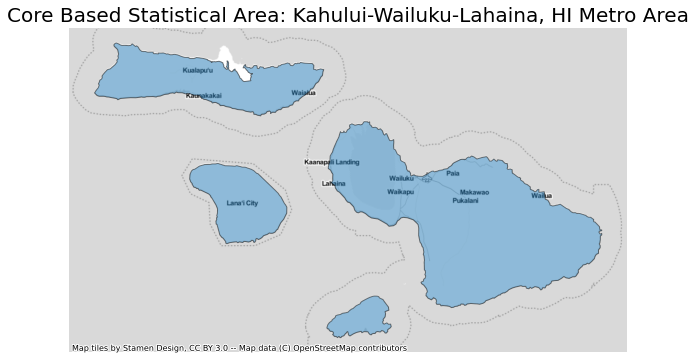

In [36]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME == "Kahului-Wailuku-Lahaina, HI"].plot(
    figsize=(10, 10), alpha=0.5, edgecolor="k"
)
ax.set_title(
    "Core Based Statistical Area: Kahului-Wailuku-Lahaina, HI Metro Area",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the Kahului-Wailuku-Lahaina, HI Metro Area, Core Based Statistical Area.

**[Jump to Top](#United-States-2020-Census-data)**

#### Combined Statistical Areas (CSA)

This file contains data on [Combined Statistical Areas](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_7), which are areas that consist of two or more adjacent CBSAs that have significant employment interchanges.

The attribute table contains the following information:

* CSAFP = Combined statistical area code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = CSAFP
* NAME = CSA Name
* NAMELSAD = CSA name and legal/statistical description
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for CSA polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the CSA data from the parquet file of the Planetary Computer dataset:

In [37]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_csa_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

CSAFP      AFFGEOID GEOID                                  NAME  \
0    146  330M600US146   146        Bloomsburg-Berwick-Sunbury, PA   
1    368  330M600US368   368        Memphis-Forrest City, TN-MS-AR   
2    356  330M600US356   356  Macon-Bibb County--Warner Robins, GA   
3    290  330M600US290   290                Huntsville-Decatur, AL   
4    206  330M600US206   206              Dallas-Fort Worth, TX-OK   

                                   NAMELSAD LSAD        ALAND      AWATER  \
0        Bloomsburg-Berwick-Sunbury, PA CSA   M0   4444039108    86464626   
1        Memphis-Forrest City, TN-MS-AR CSA   M0  13493874541   322004792   
2  Macon-Bibb County--Warner Robins, GA CSA   M0   5827265752    49165153   
3                Huntsville-Decatur, AL CSA   M0   6816635309   269975554   
4              Dallas-Fort Worth, TX-OK CSA   M0  40234482778  1682397922   

                                            geometry  
0  POLYGON ((-77.36418 40.84694, -77.27924 40.909...  
1  POLYGON ((-91.15230 34.92548, -91.15074 34.968...  
2  POLYGON ((-84.20263 32.69002, -84.19676 32.701...  
3  POLYGON ((-87.53028 34.45756, -87.53011 34.469...  
4  POLYGON ((-98.57613 32.57248, -98.57600 32.624...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select the San Jose-San Francisco-Oakland CSA by filtering by the NAME column.

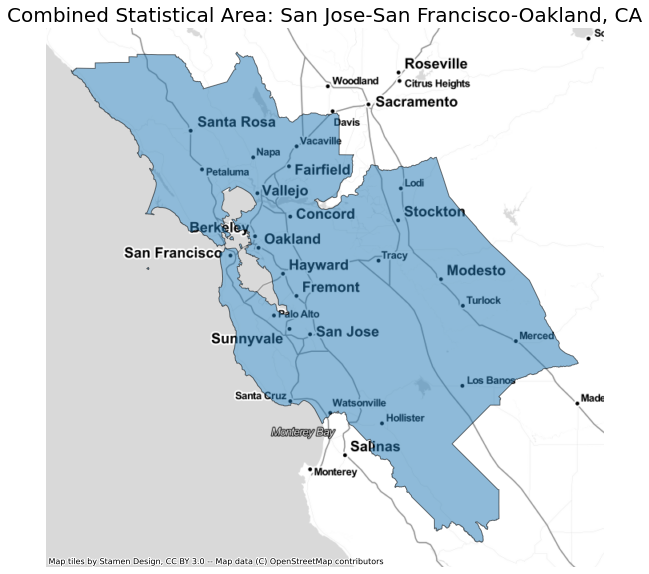

In [38]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME == "San Jose-San Francisco-Oakland, CA"].plot(
    figsize=(10, 10), alpha=0.5, edgecolor="k"
)
ax.set_title(
    "Combined Statistical Area: San Jose-San Francisco-Oakland, CA",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the San Jose-San Francisco-Oakland, CA Combined Statistical Area.

**[Jump to Top](#United-States-2020-Census-data)**

#### Metropolitan Divisions (METDIV)

This file contains data on [Metropolitan Divisions](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_7). These areas are groupings of counties or equivalent entities within a metropolitan statistical area with a core of 2.5 million inhabitants and one or more main counties that represent employment centers, plus adjacent counties with commuting ties.

The attribute table contains the following information:

* CSAFP = Combined statistical area code
* CBSAFP = Metropolitan statistical area/micropolitan statistical area code
* METDIVFP = Metropolitan division code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of CBSAFP and METDIVFP
* NAME = Metropolitan division name
* NAMELSAD = MetDiv name and legal/statistical description
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Metropolitan Division polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Metropolitan Division data from the parquet file of the Planetary Computer dataset:

In [39]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_metdiv_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

CSAFP  CBSAFP  METDIVFP             AFFGEOID       GEOID  \
0    348   31080     11244  314M600US3108011244  3108011244   
1    148   14460     14454  314M600US1446014454  1446014454   
2    148   14460     15764  314M600US1446015764  1446015764   
3    428   37980     15804  314M600US3798015804  3798015804   
4    176   16980     16984  314M600US1698016984  1698016984   

                              NAME  \
0     Anaheim-Santa Ana-Irvine, CA   
1                       Boston, MA   
2  Cambridge-Newton-Framingham, MA   
3                       Camden, NJ   
4  Chicago-Naperville-Evanston, IL   

                                         NAMELSAD LSAD       ALAND  \
0     Anaheim-Santa Ana-Irvine, CA Metro Division   M3  2053449483   
1                       Boston, MA Metro Division   M3  2882301581   
2  Cambridge-Newton-Framingham, MA Metro Division   M3  3393859579   
3                       Camden, NJ Metro Division   M3  3477449505   
4  Chicago-Naperville-Evanston, IL Metro Division   M3  8106981077   

       AWATER                                           geometry  
0   406294114  POLYGON ((-118.11442 33.74518, -118.11305 33.7...  
1  1411559356  MULTIPOLYGON (((-70.88335 42.34049, -70.88158 ...  
2   945476893  MULTIPOLYGON (((-70.58029 42.63602, -70.57509 ...  
3   108072755  POLYGON ((-75.42830 39.78437, -75.42168 39.787...  
4  1895152877  POLYGON ((-88.70738 42.49359, -88.67080 42.494...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select out Chicago-Naperville-Evanston, IL Metropolitan Divisions by filtering by the NAME column.

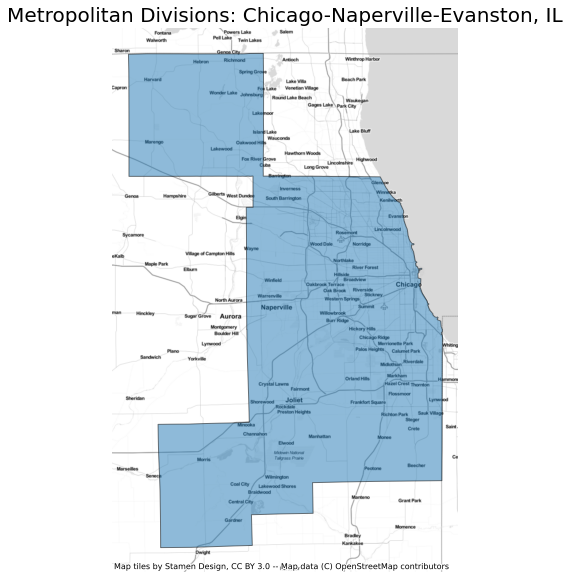

In [40]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME == "Chicago-Naperville-Evanston, IL"].plot(
    figsize=(10, 10), alpha=0.5, edgecolor="k"
)
ax.set_title(
    "Metropolitan Divisions: Chicago-Naperville-Evanston, IL",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Metropolitan Divisions in Illinois and Indiana.

**[Jump to Top](#United-States-2020-Census-data)**

#### New England City and Town Areas (NECTA)

This file contains [New England City and Town Areas](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_7), which encompass metropolitan and micropolitan statistical areas and urban clusters in New England.

The attribute table contains the following information:

* CNECTAFP = Combined NECTA code
* NECTAFP = NECTA code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = NECTAFP
* NAME = NECTA name
* NAMELSAD = NECTA name and legal/statistical description
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for New England City and Town Area polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the New England City and Town Areas data from the parquet file of the Planetary Computer dataset:

In [41]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_necta_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

CNECTAFP  NECTAFP        AFFGEOID  GEOID                    NAME  \
0      790    73300  350M600US73300  73300     Greenfield Town, MA   
1      725    72500  350M600US72500  72500           Claremont, NH   
2      NaN    73050  350M600US73050  73050     Dover-Durham, NH-ME   
3      NaN    78500  350M600US78500  78500      Vineyard Haven, MA   
4      715    74500  350M600US74500  74500  Leominster-Gardner, MA   

                                    NAMELSAD LSAD       ALAND     AWATER  \
0     Greenfield Town, MA Micropolitan NECTA   M6   576790797   12695651   
1           Claremont, NH Micropolitan NECTA   M6   207547766    2886013   
2     Dover-Durham, NH-ME Metropolitan NECTA   M5  1153772202   38371631   
3      Vineyard Haven, MA Micropolitan NECTA   M6   233141285  675399599   
4  Leominster-Gardner, MA Metropolitan NECTA   M5  1028154238   65184023   

                                            geometry  
0  POLYGON ((-72.85766 42.73761, -72.80911 42.736...  
1  POLYGON ((-72.41538 43.38021, -72.41315 43.384...  
2  POLYGON ((-71.24697 43.27619, -71.23601 43.284...  
3  MULTIPOLYGON (((-70.83204 41.25950, -70.82983 ...  
4  POLYGON ((-72.31363 42.39640, -72.31509 42.398...

Next, plot all polygons from this parquet file and overlay all of the New England City and Town Areas on a basemap.

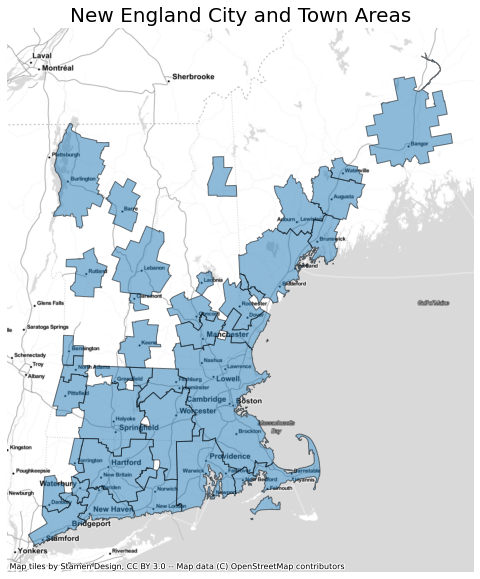

In [42]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "New England City and Town Areas",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows New England City and Town Areas.

**[Jump to Top](#United-States-2020-Census-data)**

#### New England City and Town Area Division (NECTADIV)

This file contains [New England City and Town Areas Divisions](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_7), which are smaller groupings of cities and towns in New England that contain a single core of 2.5 million inhabitants. Each division must have a total population of 100,000 or more.

The attribute table contains the following information:

* CNECTAFP = Combined NECTA code
* NECTAFP = NECTA code
* NCTADVFP = NECTA Division code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of NECTA code and NECT division code
* NAME = NECTA Division name
* NAMELSAD = NECTA Division name and legal/statistical description
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for New England City and Town Area Division polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the New England City and Town Areas Divisions data from the parquet file of the Planetary Computer dataset:

In [43]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_nectadiv_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

CNECTAFP  NECTAFP  NCTADVFP             AFFGEOID       GEOID  \
0      715    71650     78254  355M600US7165078254  7165078254   
1      715    71650     73604  355M600US7165073604  7165073604   
2      715    71650     74204  355M600US7165074204  7165074204   
3      715    71650     71634  355M600US7165071634  7165071634   
4      715    71650     72104  355M600US7165072104  7165072104   

                                         NAME  \
0            Taunton-Middleborough-Norton, MA   
1  Haverhill-Newburyport-Amesbury Town, MA-NH   
2  Lawrence-Methuen Town-North Andover, MA-NH   
3                 Boston-Cambridge-Newton, MA   
4        Brockton-Bridgewater Town-Easton, MA   

                                            NAMELSAD LSAD       ALAND  \
0    Taunton-Middleborough-Norton, MA NECTA Division   M7   777613767   
1  Haverhill-Newburyport-Amesbury Town, MA-NH NEC...   M7   938908432   
2  Lawrence-Methuen Town-North Andover, MA-NH NEC...   M7   207887604   
3         Boston-Cambridge-Newton, MA NECTA Division   M7  2860356873   
4  Brockton-Bridgewater Town-Easton, MA NECTA Div...   M7   321543380   

      AWATER                                           geometry  
0   49344655  POLYGON ((-71.25929 41.97422, -71.23516 41.983...  
1   56403579  POLYGON ((-71.31096 42.93573, -71.30006 42.969...  
2    9753119  POLYGON ((-71.28426 42.76011, -71.26375 42.785...  
3  425756189  MULTIPOLYGON (((-70.95108 42.28973, -70.94864 ...  
4    7532122  POLYGON ((-71.16747 42.06163, -71.14226 42.071...

Next, plot all polygons from this parquet file and overlay all of the New England City and Town Area Divisions on a basemap.

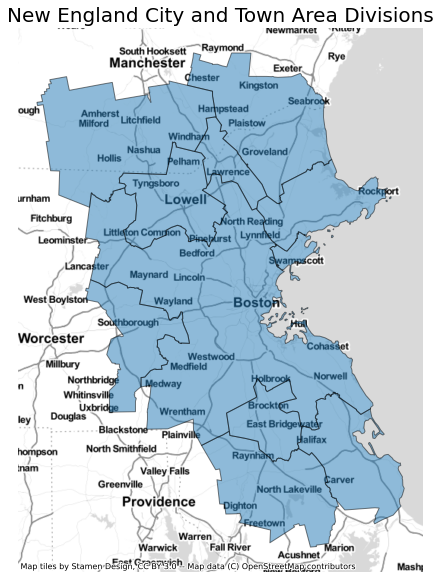

In [44]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "New England City and Town Area Divisions",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows New England City and Town Area Divisions.

**[Jump to Top](#United-States-2020-Census-data)**

#### Combined New England City and Town Areas (CNECTA)

This file contains data on [Combined New England City and Town Areas](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_7), consisting of two or more adjacent NECTAs that have significant employment interchanges.

The attribute table contains the following information:

* CNECTAFP = Combined NECTA code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = CNECTA
* NAME = Combined NECTA name
* NAMELSAD = Combined NECTA name and legal/statistical description
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Combined New England City and Town Area polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Combined New England City and Town Areas data from the parquet file of the Planetary Computer dataset:

In [45]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_cnecta_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

CNECTAFP      AFFGEOID GEOID                                         NAME  \
0      710  335M600US710   710                       Augusta-Waterville, ME   
1      715  335M600US715   715  Boston-Worcester-Providence, MA-RI-NH-CT-ME   
2      720  335M600US720   720            Bridgeport-New Haven-Stamford, CT   
3      725  335M600US725   725                     Lebanon-Claremont, NH-VT   
4      770  335M600US770   770                Pittsfield-North Adams, MA-VT   

                                            NAMELSAD LSAD        ALAND  \
0              Augusta-Waterville, ME Combined NECTA   M4   2155041281   
1  Boston-Worcester-Providence, MA-RI-NH-CT-ME Co...   M4  21419143755   
2   Bridgeport-New Haven-Stamford, CT Combined NECTA   M4   3939856869   
3            Lebanon-Claremont, NH-VT Combined NECTA   M4   3032422367   
4       Pittsfield-North Adams, MA-VT Combined NECTA   M4   1524388842   

       AWATER                                           geometry  
0   183932221  POLYGON ((-70.04529 44.49481, -70.04230 44.494...  
1  3004992276  MULTIPOLYGON (((-70.58029 42.63602, -70.57509 ...  
2   374600689  MULTIPOLYGON (((-72.76143 41.24233, -72.75973 ...  
3    58164272  POLYGON ((-72.64469 43.79013, -72.62226 43.817...  
4    24505481  POLYGON ((-73.40063 42.37903, -73.39156 42.403...

Next, plot all polygons from this parquet file and overlay all of the Combined New England City and Town Areas on a basemap.

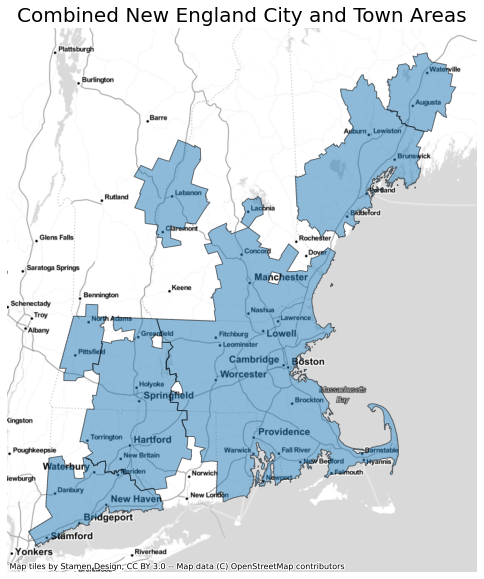

In [46]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Combined New England City and Town Areas",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Combined New England City and Town Areas.

**[Jump to Top](#United-States-2020-Census-data)**

### Places (PLACE)

This file contains [Places](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_14) which are Incorporated Places (legal entities) and Census Designated Places (CDPs, statistical entities). An incorporated place usually is a city, town, village, or borough but can have other legal descriptions. CDPs are settled concentrations of population that are identifiable by name but are not legally incorporated.

The attribute table contains the following information:

* STATEFP = State FIPS code
* PLACEFP = Place FIPS code
* PLACENS = Place GNIS code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS code and Place FIPS code
* NAME = Place name
* NAMELSAD = Place name and legal/statistical description
* STUSPS = FIPS Postal code
* STATE_NAME = State name
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Place polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Places data from the parquet file of the Planetary Computer dataset:

In [47]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_place_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP  PLACEFP  PLACENS          AFFGEOID    GEOID        NAME  \
0      12    28575  2403791  1600000US1228575  1228575     Hampton   
1      12      625  2405131  1600000US1200625  1200625      Alford   
2      12    26050  2406576  1600000US1226050  1226050  Glen Ridge   
3      13    69000  2405429  1600000US1369000  1369000    Savannah   
4      13    67284  2404651  1600000US1367284  1367284     Roswell   

          NAMELSAD STUSPS STATE_NAME LSAD      ALAND    AWATER  \
0     Hampton city     FL    Florida   25    2728657         0   
1      Alford town     FL    Florida   43    2731534     49685   
2  Glen Ridge town     FL    Florida   43     442668     54824   
3    Savannah city     GA    Georgia   25  276730651  12329738   
4     Roswell city     GA    Georgia   25  105461127   3308483   

                                            geometry  
0  POLYGON ((-82.15433 29.86419, -82.14682 29.864...  
1  POLYGON ((-85.40333 30.70450, -85.39543 30.704...  
2  POLYGON ((-80.08267 26.67634, -80.07902 26.676...  
3  MULTIPOLYGON (((-81.23851 32.06725, -81.21279 ...  
4  POLYGON ((-84.41903 34.06118, -84.41903 34.061...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select all the Places in Washington State by filtering by `"WA"` in the STUSPS column.

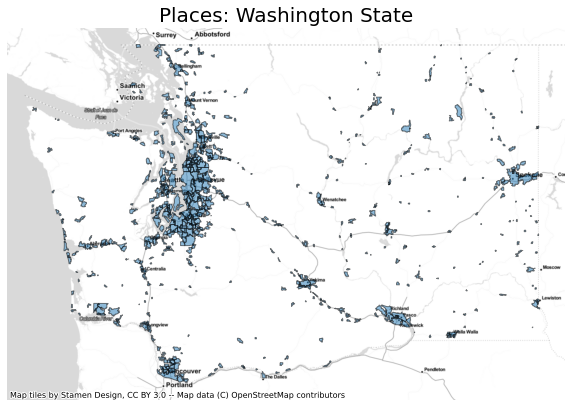

In [48]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.STUSPS == "WA"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Places: Washington State",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Places in Washington State.

**[Jump to Top](#United-States-2020-Census-data)**

### Regions (REGION)

This file contains [Regions](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_10) of the US and encompasses several states per division.

The attribute table contains the following information:

* REGIONCE = Number assigned to each Region
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = REGIONCE
* NAME = Name of region
* NAMELSAD = Region name and legal/statistical description
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Region polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Regions data from the parquet file of the Planetary Computer dataset:

In [49]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_region_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

REGIONCE    AFFGEOID GEOID       NAME          NAMELSAD LSAD  \
0         3  0200000US3     3      South      South Region   68   
1         2  0200000US2     2    Midwest    Midwest Region   68   
2         4  0200000US4     4       West       West Region   68   
3         1  0200000US1     1  Northeast  Northeast Region   68   

           ALAND        AWATER  \
0  2249827294436  148750821211   
1  1943998021072  184282989466   
2  4537345771989  315439166576   
3   419355661549   50259697277   

                                            geometry  
0  MULTIPOLYGON (((-89.34216 30.05917, -89.33606 ...  
1  MULTIPOLYGON (((-82.73447 41.60351, -82.72425 ...  
2  MULTIPOLYGON (((-147.46941 60.92206, -147.4682...  
3  MULTIPOLYGON (((-67.32260 44.61160, -67.32174 ...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select the entire South Region by filtering by the NAME column.

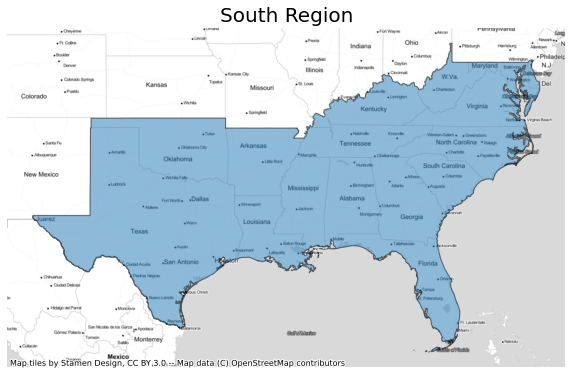

In [50]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME == "South"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "South Region",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the South Region.

**[Jump to Top](#United-States-2020-Census-data)**

### School Districts 

[School Districts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_23) is the third grouping of datasets within the census data by cartographic boundaries group. This dataset grouping includes district boundaries for Elementary School Districts, Secondary School Districts, and Unified School Districts.

#### School Districts - Elementary (ELSD)

This file contains [Elementary School Districts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_23), referring to districts with elementary schools.

The attribute table contains the following information:

* STATEFP = State FIPS code
* ELSDLEA = Elementary School District local education agency code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS code and ELSDLEA code
* NAME = Elementary School District name
* STUSPS = FIPS Postal code
* STATE_NAME = State name
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Elementary School District polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Elementary School Districts data from the parquet file of the Planetary Computer dataset:

In [51]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_elsd_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP  ELSDLEA          AFFGEOID    GEOID  \
0      17    42570  9500000US1742570  1742570   
1      40     4470  9500000US4004470  4004470   
2      17     8790  9500000US1708790  1708790   
3      34     5520  9500000US3405520  3405520   
4      17    17160  9500000US1717160  1717160   

                                 NAME STUSPS  STATE_NAME LSAD     ALAND  \
0  Willow Springs School District 108     IL    Illinois   00  24565916   
1                Bishop Public School     OK    Oklahoma   00  18936631   
2             Cass School District 63     IL    Illinois   00  11006857   
3   Franklin Township School District     NJ  New Jersey   00  60657041   
4            Gower School District 62     IL    Illinois   00  13484773   

    AWATER                                           geometry  
0  2685308  POLYGON ((-87.91426 41.71660, -87.90923 41.719...  
1        0  POLYGON ((-98.44840 34.59449, -98.43973 34.594...  
2   329296  POLYGON ((-88.00218 41.72823, -88.00230 41.729...  
3   232602  POLYGON ((-75.10323 40.71943, -75.06000 40.753...  
4   437292  POLYGON ((-87.96002 41.75215, -87.95929 41.752...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select all the Elementary School Districts in Montana by filtering by `"MT"` in the STUSPS column.

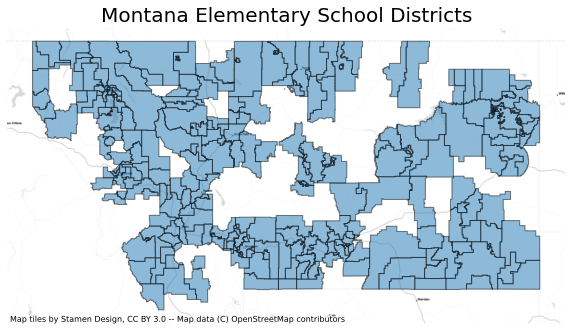

In [52]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.STUSPS == "MT"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Montana Elementary School Districts",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the Montana Elementary School Districts.

**[Jump to Top](#United-States-2020-Census-data)**

#### School Districts - Secondary (SCSD)

This file contains [Secondary School Districts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_23), referring to districts with secondary schools.

The attribute table contains the following information:

* STATEFP = State FIPS code
* SCDLEA = Secondary School District local education agency code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS code and SCSDLEA code
* NAME = Secondary School District name
* STUSPS = FIPS Postal code. STATE_NAME = State name
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = Coordinates for Secondary School District polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Secondary School Districts data from the parquet file of the Planetary Computer dataset:

In [53]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_scsd_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP  SCSDLEA          AFFGEOID    GEOID  \
0      06    99004  9600000US0699004  0699004   
1      17    99001  9600000US1799001  1799001   
2      17    33720  9600000US1733720  1733720   
3      06    21600  9600000US0621600  0621600   
4      06    25150  9600000US0625150  0625150   

                                                NAME STUSPS  STATE_NAME LSAD  \
0              Sierra Unified School District (9-12)     CA  California   00   
1  Bluford Unit School District 318 (9-12) in Far...     IL    Illinois   00   
2       Ridgewood Community High School District 234     IL    Illinois   00   
3                 Liberty Union High School District     CA  California   00   
4                  Modesto City High School District     CA  California   00   

        ALAND    AWATER                                           geometry  
0  2950629174  63592439  POLYGON ((-119.40472 37.09651, -119.39820 37.0...  
1    99593597    219159  POLYGON ((-88.81637 38.38809, -88.81180 38.388...  
2     6948669         0  POLYGON ((-87.84656 41.96914, -87.84654 41.971...  
3   504991993  61858554  POLYGON ((-121.83236 37.93557, -121.83236 37.9...  
4   430136526   3637374  POLYGON ((-121.24123 37.66425, -121.24003 37.6...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select all the Secondary School Districts in Arizona by filtering by `"AZ"` in the STUSPS column.

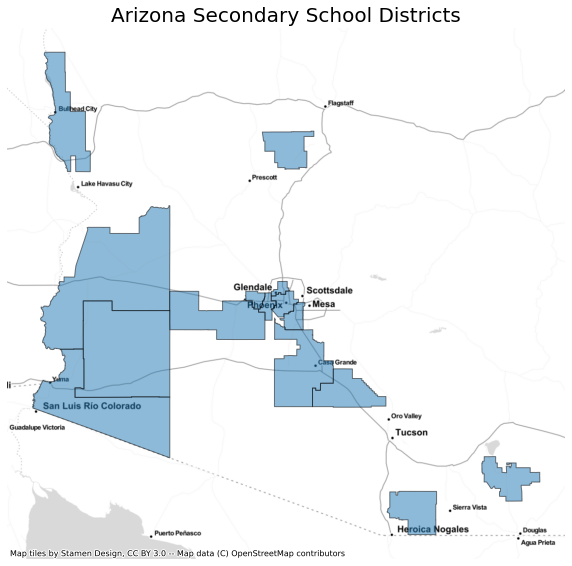

In [54]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.STUSPS == "AZ"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Arizona Secondary School Districts",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the Arizona Secondary School Districts.

**[Jump to Top](#United-States-2020-Census-data)**

#### School Districts - Unified (UNSD)

This file contains [Unified School Districts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_23), referring to districts that provide education to children of all school ages. Unified school districts can have both secondary and elementary schools.

The attribute table contains the following information:

* STATEFP = State FIPS code
* UNSDLEA = Unified School District local education agency code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS code and UNSDLEA code
* NAME = Unified School District name
* STUSPS = FIPS Postal code
* STATE_NAME = State name
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = Coordinates for Unified School District polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Unified School Districts data from the parquet file of the Planetary Computer dataset:

In [55]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_unsd_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP  UNSDLEA          AFFGEOID    GEOID  \
0      36    18210  9700000US3618210  3618210   
1      29    21660  9700000US2921660  2921660   
2      29     9930  9700000US2909930  2909930   
3      29    11550  9700000US2911550  2911550   
4      51     2490  9700000US5102490  5102490   

                                           NAME STUSPS STATE_NAME LSAD  \
0           Malverne Union Free School District     NY   New York   00   
1  Northeast Nodaway County R-V School District     MO   Missouri   00   
2               Blair Oaks R-II School District     MO   Missouri   00   
3               Cole County R-V School District     MO   Missouri   00   
4               Middlesex County Public Schools     VA   Virginia   00   

       ALAND     AWATER                                           geometry  
0    5271104     539214  POLYGON ((-73.67603 40.67130, -73.67428 40.672...  
1  292199326      69164  POLYGON ((-94.78484 40.37451, -94.77798 40.373...  
2  181982856    5337193  POLYGON ((-92.25955 38.37702, -92.25574 38.381...  
3  368295288    3182437  POLYGON ((-92.46801 38.31442, -92.46697 38.327...  
4  337554148  208310589  MULTIPOLYGON (((-76.42081 37.59787, -76.41957 ...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, select the entire New York City Unified School District, which encompasses the five counties of NYC. Select the relevant data by filtering by the NAME column.

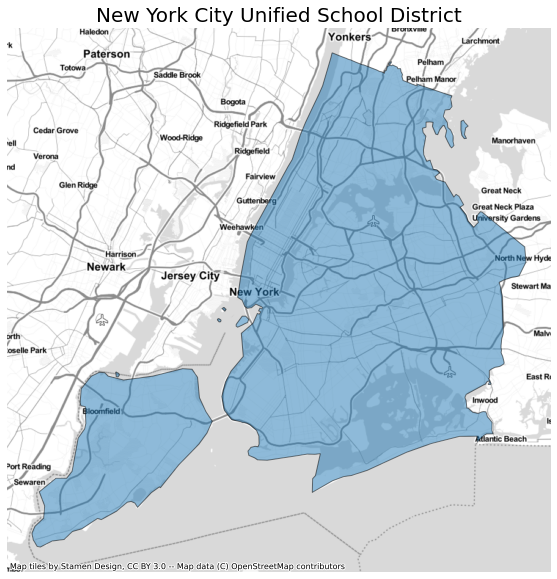

In [56]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME == "New York City Department Of Education"].plot(
    figsize=(10, 10), alpha=0.5, edgecolor="k"
)
ax.set_title(
    "New York City Unified School District",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the New York City Unified School District.

**[Jump to Top](#United-States-2020-Census-data)**

### State Legislative Districts

[State Legislative Districts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_24) is the fourth grouping of datasets within the census data by cartographic boundaries group.
This dataset grouping includes State Legislative Districts for both Upper and Lower State Chambers. These are areas in which voters elect a person to represent them in state or equivalent entity legislatures. Most states have both upper and lower chambers, the exceptions being Nebraska which has a unicameral legislature, and Washington, DC, which has a single council. As a result, there is no lower house data for Nebraska and DC.

#### State Legislative Districts - Lower Chamber (SLDL)



This file contains [Lower Chamber State Legislative Districts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_24).

The attribute table contains the following information:

* STATEFP = State FIPS code
* SLDLST = State Legislative District Lower Chamber code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS code and SLDLST
* NAME = District Name
* NAMELSAD = District name and legal/statistical description
* STUSPS = FIPS Postal code
* STATE_NAME = State name
* LSAD = Legal/statistical classification
* LSY = Legislative Session Year
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Lower Chamber polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Lower Chamber State Legislative Districts data from the parquet file of the Planetary Computer dataset:

In [57]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_sldl_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP SLDLST        AFFGEOID  GEOID NAME                 NAMELSAD STUSPS  \
0      37    067  620L600US37067  37067   67  State House District 67     NC   
1      37    023  620L600US37023  37023   23  State House District 23     NC   
2      39    078  620L600US39078  39078   78  State House District 78     OH   
3      41    026  620L600US41026  41026   26  State House District 26     OR   
4      41    015  620L600US41015  41015   15  State House District 15     OR   

       STATE_NAME LSAD   LSY       ALAND    AWATER  \
0  North Carolina   LL  2018  1372481845  13054913   
1  North Carolina   LL  2018  2498112701   4460107   
2            Ohio   LL  2018  3609975942  28657516   
3          Oregon   LL  2018   209051898   1046849   
4          Oregon   LL  2018   517343089   8286102   

                                            geometry  
0  POLYGON ((-80.67249 35.28457, -80.66859 35.284...  
1  POLYGON ((-77.82844 35.86721, -77.82613 35.871...  
2  POLYGON ((-83.01738 39.73643, -83.01428 39.738...  
3  POLYGON ((-122.95072 45.44942, -122.94726 45.4...  
4  POLYGON ((-123.26079 44.55749, -123.26025 44.5...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, plot all the Lower Chamber State Legislative Districts in Texas by filtering by `"TX"` in the STUSPS column.

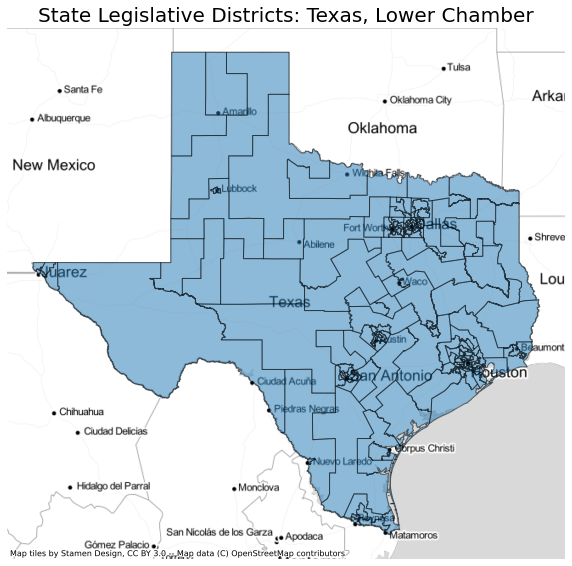

In [58]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.STUSPS == "TX"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "State Legislative Districts: Texas, Lower Chamber",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the Texas Lower Chamber State Legislative Districts.

**[Jump to Top](#United-States-2020-Census-data)**

#### State Legislative Districts - Upper Chamber (SLDU)

This file contains [Upper Chamber State Legislative Districts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_24).

The attribute table contains the following information:

* STATEFP = State FIPS code
* SLDUST = State Legislative District Upper Chamber code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS code and SLDUST
* NAME = District Name
* NAMELSAD = District name and legal/statistical description
* STUSPS = FIPS Postal code
* STATE_NAME = State name
* LSAD = Legal/statistical classification
* LSY = Legislative Session Year
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Upper Chamber polygon

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Upper Chamber State Legislative Districts data from the parquet file of the Planetary Computer dataset:

In [59]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_sldu_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP SLDUST        AFFGEOID  GEOID NAME                  NAMELSAD STUSPS  \
0      41    004  610U600US41004  41004    4   State Senate District 4     OR   
1      41    015  610U600US41015  41015   15  State Senate District 15     OR   
2      42    016  610U600US42016  42016   16  State Senate District 16     PA   
3      48    015  610U600US48015  48015   15  State Senate District 15     TX   
4      51    016  610U600US51016  51016   16  State Senate District 16     VA   

     STATE_NAME LSAD   LSY        ALAND     AWATER  \
0        Oregon   LU  2018  16139528745  167874360   
1        Oregon   LU  2018    238454422     423501   
2  Pennsylvania   LU  2018    796458250    5947856   
3         Texas   LU  2018    828734514   37403360   
4      Virginia   LU  2018    580535957   32576935   

                                            geometry  
0  POLYGON ((-123.81715 43.45959, -123.81666 43.5...  
1  POLYGON ((-123.15350 45.53457, -123.15271 45.5...  
2  POLYGON ((-75.88921 40.67834, -75.85481 40.693...  
3  POLYGON ((-95.57473 29.86719, -95.56919 29.867...  
4  POLYGON ((-77.59806 37.23679, -77.59600 37.238...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, plot all the Upper Chamber State Legislative Districts in Michigan by filtering by `"MI"` in the STUSPS column.

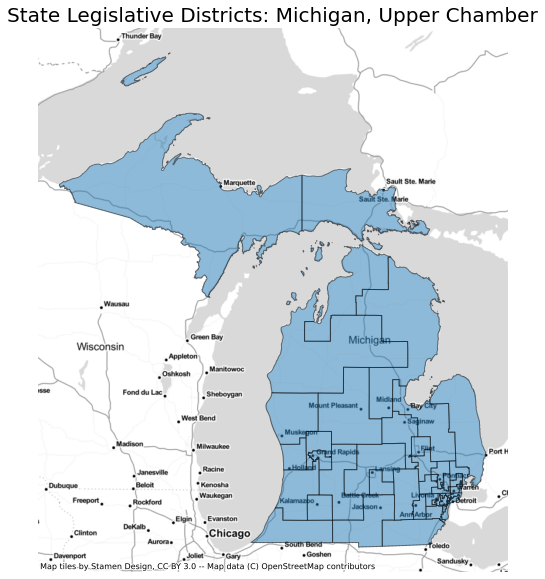

In [60]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.STUSPS == "MI"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "State Legislative Districts: Michigan, Upper Chamber",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the Michigan Upper Chamber State Legislative Districts.

**[Jump to Top](#United-States-2020-Census-data)**

### States (STATE)

This file contains the [US States and State Equivalent Entities](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_25). Within Census Bureau datasets, the District of Columbia, Puerto Rico, and the Island Areas (American Samoa, the Commonwealth of the Northern Mariana Islands, Guam, and the US Virgin Islands) are treated as statistical equivalents of states alongside the 50 US states.

The attribute table contains the following information:

* STATEFP = State FIPS code
* STATENS = State ANSI feature code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = STATEFP
* STUSPS = FIPS postal code
* NAME = State name
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for State polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the US States and State Equivalent Entities data from the parquet file of the Planetary Computer dataset:

In [61]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_state_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP  STATENS     AFFGEOID GEOID STUSPS          NAME LSAD         ALAND  \
0      66  1802705  0400000US66    66     GU          Guam   00     543555847   
1      48  1779801  0400000US48    48     TX         Texas   00  676680588914   
2      55  1779806  0400000US55    55     WI     Wisconsin   00  140292246684   
3      44  1219835  0400000US44    44     RI  Rhode Island   00    2677759219   
4      36  1779796  0400000US36    36     NY      New York   00  122049520861   

        AWATER                                           geometry  
0    934337453  MULTIPOLYGON (((144.64538 13.23627, 144.64716 ...  
1  18979352230  MULTIPOLYGON (((-94.71830 29.72885, -94.71721 ...  
2  29343721650  MULTIPOLYGON (((-86.95617 45.35549, -86.95463 ...  
3   1323691129  MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...  
4  19256750161  MULTIPOLYGON (((-72.03683 41.24984, -72.03496 ...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, plot only the contiguous US, Puerto Rico, and the US Virgin Islands. To exclude parts of the dataset from plotting, use `~df.STATEFP.isin()` to exclude the STATEFP codes for Alaska, Hawaii, Guam, American Samoa, and the Commonwealth of the Northern Mariana Islands.

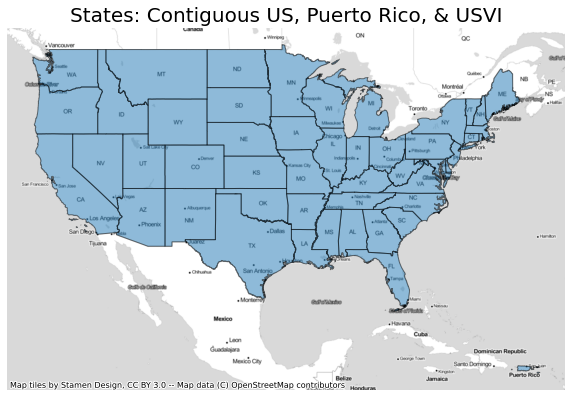

In [62]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[~ddf.STATEFP.isin(["02", "15", "60", "66", "69"])].plot(
    figsize=(10, 10), alpha=0.5, edgecolor="k"
)
ax.set_title(
    "States: Contiguous US, Puerto Rico, & USVI",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the Contiguous US, Puerto Rico, and the US Virgin Islands.

**[Jump to Top](#United-States-2020-Census-data)**

### Subbarrios (SUBBARRIO)

This file contains [Subbarrios](https://www.census.gov/programs-surveys/geography/about/glossary.html#pr), which are legally defined subdivisions of Minor Civil Division in Puerto Rico. They don"t exist within every Minor Civil Division and don"t always cover the entire Minor Civil Division where they do exist.

The attribute table contains the following information:

* STATEFP = State FIPS code
* COUNTYFP = County FIPS code
* COUSUBFP = County Subdivision FIPS code
* SUBMCDFP = Subbarrio FIPS code
* SUBMCDNS = Subbarrio ANSI feature code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* GEOID = Concatenation of State FIPS code, County FIPS code, County Subdivision FIPS code and Subbarrio FIPS code
* NAME = Subbarrio name
* NAMELSAD = Subbarrio name and legal/statistical division
* LSAD = Legal/statistical classification
* ALAND = Current land area
* AWATER = Current water area
* geometry = coordinates for Subbarrio polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Subbarrios data from the parquet file of the Planetary Computer dataset:

In [63]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_72_subbarrio_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP COUNTYFP COUSUBFP  SUBMCDFP  SUBMCDNS                  AFFGEOID  \
0      72      035    15537     65040   2415842  0670000US720351553765040   
1      72      127    84079     84771   2416087  0670000US721278407984771   
2      72      127    79693     34770   2415499  0670000US721277969334770   
3      72      013    03411     72325   2415953  0670000US720130341172325   
4      72      121    73587     64805   2415826  0670000US721217358764805   

             GEOID          NAME                NAMELSAD LSAD    ALAND  \
0  720351553765040    Pueblo Sur    Pueblo Sur subbarrio   51  2708525   
1  721278407984771      Valencia      Valencia subbarrio   51   144073   
2  721277969334770     Hipódromo     Hipódromo subbarrio   51   263788   
3  720130341172325       Rosario       Rosario subbarrio   51    58332   
4  721217358764805  Pueblo Norte  Pueblo Norte subbarrio   51   120549   

   AWATER                                           geometry  
0     517  POLYGON ((-66.18201 18.11012, -66.18182 18.110...  
1       0  POLYGON ((-66.04345 18.41148, -66.04334 18.411...  
2       0  POLYGON ((-66.07415 18.44463, -66.07115 18.448...  
3   12520  POLYGON ((-66.71531 18.47233, -66.71231 18.472...  
4       0  POLYGON ((-66.96232 18.07969, -66.96186 18.080...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, plot all the Subbarrios in the San Juan Municipo (the county equivalent for Puerto Rico). Select the relevant data by filtering by the COUNTYFP column.

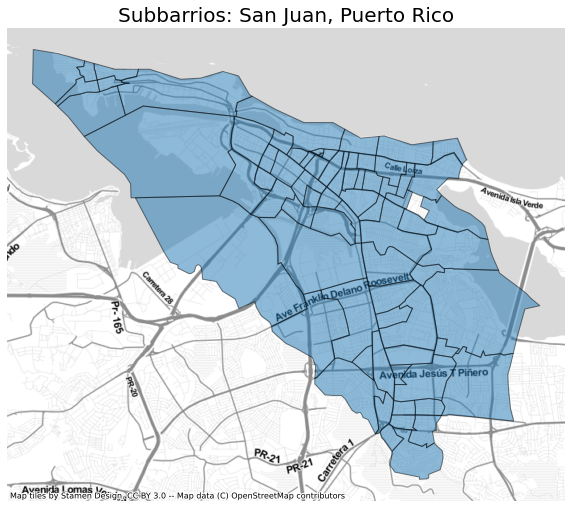

In [64]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.COUNTYFP == "127"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Subbarrios: San Juan, Puerto Rico",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the Subbarrios in San Juan Municipo.

**[Jump to Top](#United-States-2020-Census-data)**

### United States Outline

This file contains the [United States Outline](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_30) shapefile. This contains all 50 US states plus the District of Columbia, Puerto Rico, and the Island Areas (American Samoa, the Commonwealth of the Northern Mariana Islands, Guam, and the US Virgin Islands). There is only one feature within this dataset.

The attribute table for this dataset only contains the AFFGEOID, GEOID, NAME, and coordinates for the US polygon.

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the United States Outline data from the parquet file of the Planetary Computer dataset:

In [65]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_nation_5m").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

AFFGEOID GEOID           NAME  \
0  0100000US    US  United States   

                                            geometry  
0  MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...

Next, plot the entire data from this parquet file and overlay it on a basemap. Since this dataset contains only one feature, there are no options to select or exclude specific parts based on attributes.

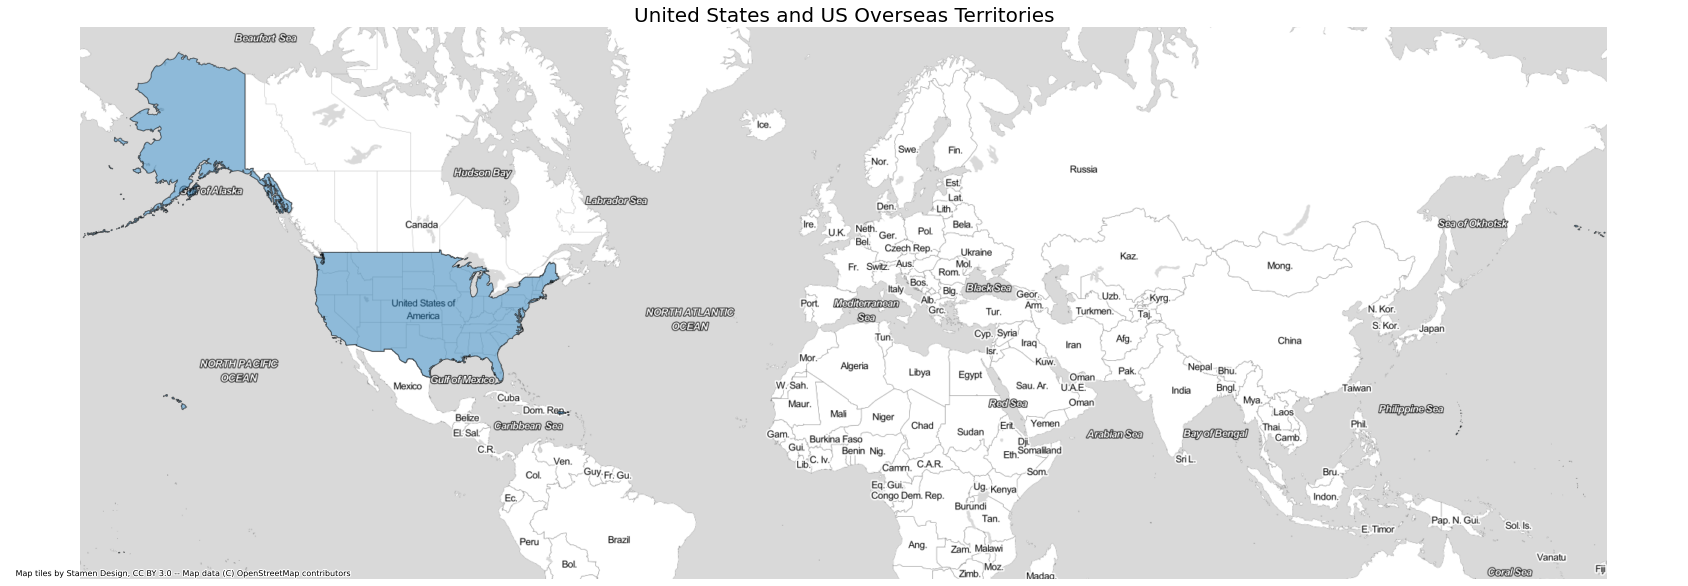

In [66]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf.plot(figsize=(30, 60), alpha=0.5, edgecolor="k")
ax.set_title(
    "United States and US Overseas Territories",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows the United States and US Overseas Territories.

**[Jump to Top](#United-States-2020-Census-data)**

### Voting Districts (VTD)

This file contains all [US Voting Districts](https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_31), which are geographic features established by state, local and tribal governments to conduct elections.

The attribute table contains the following information:

* STATEFP20 = State FIPS code
* COUNTYFP20 = County FIPS code
* VTDST20 = Voting district code
* AFFGEOID = American FactFinder summary level code + geovariant code + "00US" + GEOID
* EOID = Concatenation of State FIPS code, County FIPS code, and Voting District code
* VTDI20 = Voting district indicator
* NAME20 = Voting district name
* NAMELSAD20 = Voting district name and legal/statistical division
* LSAD20 = Legal/statistical classification
* ALAND20 = Current land area
* AWATER20 = Current water area
* geometry = coordinates for Voting District polygons

Use the [read_parquet](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.read_parquet.html) function of [Dask-GeoPandas](https://github.com/geopandas/dask-geopandas) to read the Voting Districts data from the parquet file of the Planetary Computer dataset:

In [67]:
asset = planetary_computer.sign(
    census.get_item("2020-cb_2020_us_vtd_500k").assets["data"]
)
ddf = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf.head()

STATEFP20 COUNTYFP20 VTDST20            AFFGEOID20      GEOID20 VTDI20  \
0        24        003  06-024  7000000US2400306-024  2400306-024      A   
1        24        047  01-002  7000000US2404701-002  2404701-002      A   
2        02        090  06-150  7000000US0209006-150  0209006-150      A   
3        26        101  101001  7000000US26101101001  26101101001      A   
4        26        055  055007  7000000US26055055007  26055055007      A   

                         NAME20                     NAMELSAD20 LSAD20  \
0  ANNE ARUNDEL PRECINCT 06-024   ANNE ARUNDEL PRECINCT 06-024     00   
1     WORCESTER PRECINCT 01-002      WORCESTER PRECINCT 01-002     00   
2                  Fox Precinct                   Fox Precinct     00   
3                 1010332000001  Voting District 1010332000001     V1   
4                 0552380000001  Voting District 0552380000001     V1   

      ALAND20  AWATER20                                           geometry  
0     2756767  21979454  POLYGON ((-76.48621 38.92784, -76.48142 38.928...  
1   111861087   1934368  MULTIPOLYGON (((-75.30048 38.09594, -75.29902 ...  
2  2241567797         0  POLYGON ((-148.11011 65.20532, -148.10451 65.2...  
3    48159260   1006220  POLYGON ((-86.25160 44.46544, -86.25091 44.469...  
4     9967698         0  POLYGON ((-85.57537 44.75340, -85.57330 44.752...

Next, plot the data from this parquet file and overlay it on a basemap. For this example, plot all the Voting Districts in Salt Lake City, UT by filtering by Voting District Names that begin with `"Salt Lake"` in the NAME20 column.

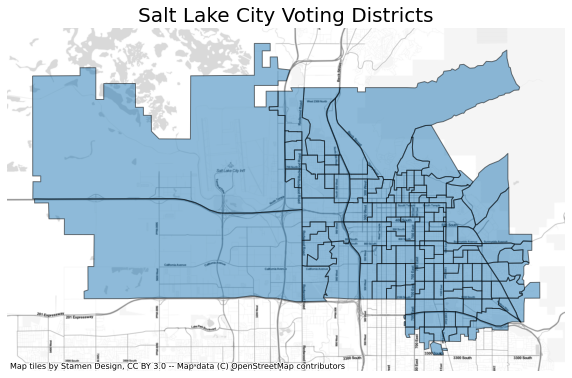

In [68]:
ddf.crs = 4326
ddf = ddf.to_crs(epsg=3857)

ax = ddf[ddf.NAME20.str.startswith("Salt Lake")].plot(
    figsize=(10, 10), alpha=0.5, edgecolor="k"
)
ax.set_title(
    "Salt Lake City Voting Districts",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

The map created shows Salt Lake City Voting Districts.

**[Jump to Top](#United-States-2020-Census-data)**